## save out the concated voxels and thier corresponding features 

In [1]:
import os
import gc
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
import statsmodels.api as sm
from os.path import join as pjoin
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import zscore
from joblib import Parallel, delayed
import time 
import joblib
import matplotlib.pyplot as plt
import pickle
from utils import train_data_normalization, Timer, net_size_info, conv2_labels, get_roi_data


In [2]:
# Define the 2D Gaussian function
def gaussian_2d(coords, A, x_0, y_0, sigma_x, sigma_y,C):
    i, j = coords
    return A * np.exp(-((i - x_0)**2 / (2 * sigma_x**2) + (j - y_0)**2 / (2 * sigma_y**2))) + C

def calc_explained_var_and_corr(x, beta, y):
    return  1 - np.mean((x @ beta - y)**2) / np.var(y), np.corrcoef(x @ beta, y)[0, 1]

def adjust_RF(receptive_field):
    cur_receptive_field = receptive_field.copy()
    cur_receptive_field = cur_receptive_field + np.abs(np.min(cur_receptive_field, None)) + 1
    thres = np.min(cur_receptive_field) + 0.5*(np.max(cur_receptive_field) - np.min(cur_receptive_field)) # 
    # if np.mean(receptive_field < thres) < 0.1:
    #     thres = np.mean(receptive_field)
    cur_receptive_field[cur_receptive_field < thres] = 0
    cur_receptive_field = cur_receptive_field / (cur_receptive_field.sum() + 1e-20)
    # if (~np.isfinite(cur_receptive_field)).any():
    #     print('use full gaussian')
    #     cur_receptive_field = receptive_field + np.abs(np.min(receptive_field, None))
    #     cur_receptive_field = cur_receptive_field / (cur_receptive_field.sum() + 1e-20)
    return cur_receptive_field


# def save_result(result, indexname):
#     global performance_path, voxels, sub, mask_name, layername
#     if result.ndim > 1:
#         all_performace = np.nan * np.zeros((result.shape[1], 59412))
#         all_performace[:, np.array(voxels)] = np.array(result).transpose()
#     else:
#         all_performace = np.nan * np.zeros((1, 59412))
#         all_performace[0, np.array(voxels)] = np.array(result)
#     np.save(pjoin(performance_path, sub, f'{sub}_bm-{mask_name}_layer-{layername}_{indexname}.npy'), all_performace)

In [3]:
def concate_voxel_resp_and_feature(idx, voxel):
    global X, X_test, y, y_test, i, j, labels
    if not voxel in guassparams.keys():
        pass
    else:
        print(f'{sub} : {idx} == {voxel}')
        receptive_field = gaussian_2d((i, j), *guassparams[voxel])
        receptive_field = adjust_RF(receptive_field)
        # saptial summation
        X_voxel = np.sum(X * receptive_field, axis=(2,3))
        X_voxel_test = np.sum(X_test * receptive_field, axis=(2,3))
        
        # 特征标准化, 均值都已经减掉了
        X_voxel = zscore(X_voxel)
        X_voxel_test = zscore(X_voxel_test)# (X_voxel_test - X_voxel.mean(axis=0))/ X_voxel.std(axis=0)
        if np.isnan(X_voxel).any():
            train_nan = 1
            X_voxel = np.nan_to_num(X_voxel)
        if np.isnan(X_voxel_test).any():
            test_nan = 1
            X_voxel_test = np.nan_to_num(X_voxel_test)
        # 取出当前体素的训练集和测试集神经活动
        y_voxel = zscore(y[:, idx], nan_policy='omit')
        y_voxel_test = zscore(y_test[:, idx], nan_policy='omit')
        
        return {'train-feature': X_voxel, 'test-feature': X_voxel_test, 
                'train-resp' : y_voxel, 'test-resp' : y_voxel_test, 'idx': idx, 'voxel': voxel}

In [4]:
inputlayername = 'googlenet-conv2' 
layer = {'name': inputlayername, 'size': net_size_info[inputlayername.replace('raw-', '')]}#alexnet_info[inputlayername]
layername = layer['name']
layername = layername.replace('.','')
labels = conv2_labels
mask_name = 'primaryvis-in-MMP' #'fixretfloc-in-subj'
test_set_name = 'coco'

# path settings
work_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
# input path
resp_path = pjoin(work_dir, 'prep/brain_response')
opendata_cifti_pth = '/nfs/z1/userhome/GongZhengXin/NVP/data_upload/NOD/derivatives/ciftify'

voxel_mask_path = pjoin(work_dir, 'prep/voxel_masks')
image_activations_path = pjoin(work_dir, 'prep/image_activations')
retino_path = pjoin(work_dir, 'build/retinoparams')
guass_path = pjoin(work_dir, 'build/gaussianparams')
# save out path
concate_path = pjoin(work_dir, 'prep/roi-voxel-concate')
subs = [f'sub-0{isub+1}' for isub in range(0, 9)]
performance_path = pjoin(work_dir, 'build/lasso-feature-withinsub-concatevoxels')

In [ ]:
subs = [f'sub-0{isub+1}' for isub in range(0, 9)]

for sub in subs:
    with Timer() as t:
        print(sub, mask_name, layername)
        # save path
        if not os.path.exists(pjoin(concate_path, sub)):
            os.makedirs(pjoin(concate_path, sub))

        # load
        brain_resp = np.load(pjoin(resp_path, f'{sub}_imagenet_beta.npy'))
        activations = np.load(pjoin(image_activations_path, f'{sub}_{layername}.npy'))
        coco_activations = np.load(pjoin(image_activations_path, f'{test_set_name}_{layername}.npy'))
        print(f'activations shape of {activations.shape}')
        if 'conv1' in layername:
            guass_layername = layername.replace('conv1', 'conv2')
            guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'), allow_pickle=True)[0]
            print(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'))
        else:
            guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{layername}_Gauss.npy'), allow_pickle=True)[0]
        
        # load, reshape and average the resp
        test_resp = np.load(pjoin(resp_path, f'{sub}_{test_set_name}_beta.npy'))
        num_trial = test_resp.shape[0]
        num_run = int(num_trial/120)
        test_resp = test_resp.reshape((num_run, 120, 59412))
        mean_test_resp = test_resp.mean(axis=0)
        
        # load mask
        voxel_mask_nii = nib.load(pjoin(voxel_mask_path, f'nod-voxmask_{mask_name}.dlabel.nii'))
        voxel_mask = voxel_mask_nii.get_fdata()
        named_maps = [named_map.map_name for named_map in voxel_mask_nii.header.get_index_map(0).named_maps]
        # determine the mask type
        if sub in named_maps:
            voxel_mask = voxel_mask[named_maps.index(sub),:]
        # squeeze into 1 dim
        voxel_mask = np.squeeze(np.array(voxel_mask))
        # transfer mask into indices
        mask_voxel_indices = np.where(voxel_mask==1)[0]
        
        prf_path = pjoin(opendata_cifti_pth, sub, 'results/ses-prf_task-prf')
        sub_prf_file = pjoin(prf_path, 'ses-prf_task-prf_params.dscalar.nii')

        # load and modify
        prf_data = nib.load(sub_prf_file).get_fdata()
        prf_r2 = prf_data[3,:]
        r2_thres = 10
        # make mask
        prf_voxel_mask = prf_r2 > r2_thres
        # transfer mask into indices
        voxel_indices = np.array([ _ for _ in np.where(prf_voxel_mask==1)[0] if _ in mask_voxel_indices])
        print(voxel_indices)
        # generate ROI in selected voxels
        v1_voxels = np.array([ _ for _ in np.where(get_roi_data(None, 'V1')==1)[0] if _ in voxel_indices])
        v2_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V2')==1)[0] if _ in voxel_indices])
        v3_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V3')==1)[0] if _ in voxel_indices])
        v4_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V4')==1)[0] if _ in voxel_indices])
        
        # collect resp in ROI
        brain_resp = brain_resp[:, voxel_indices]
        # test_resp = test_resp[:, :, voxel_indices]
        mean_test_resp = mean_test_resp[:, voxel_indices]


        # normalization
        norm_metric = 'session'
        brain_resp = train_data_normalization(brain_resp, metric=norm_metric)
        # mean_test_resp = zscore(test_resp.mean(axis=0))
        mean_test_resp = zscore(mean_test_resp, None)
        num_voxel = brain_resp.shape[-1]

        del test_resp, voxel_mask
        gc.collect()

        # coordinate
        # Create grid data
        layer['size'] = activations.shape[-1]
        i = np.linspace(-8., 8., layer['size'])
        j = np.linspace(8., -8., layer['size'])
        i, j = np.meshgrid(i, j)

        if layername == 'googlenet-conv2':
            X = activations[:, 0:63, :, :]
            X_test = coco_activations[:, 0:63, :, :]
        else:
            X = activations
            X_test = coco_activations
        
        y = brain_resp
        y_test = mean_test_resp

        # concurrent computing
        voxels = voxel_indices.tolist()
        idxs = np.arange(num_voxel).tolist()
        # voxel_indices = voxel_indices
        results = Parallel(n_jobs=3)(delayed(concate_voxel_resp_and_feature)(idx, voxel) for idx, voxel in zip(idxs, voxels))
        # for indexname in ['train-feature', 'test-feature', 'train-resp', 'test-resp']:
        #     index = np.array([ _[indexname] for _ in results])
            # save_result(index, indexname)
        with open(pjoin(concate_path, sub, f'{sub}_concate-results.pkl'), 'wb') as f:
            pickle.dump(results, f)
            filename = pjoin(concate_path, sub, f'{sub}_concate-results.pkl')
            print(f'saved {filename}')
    print(f'{sub} consume : {t.interval} s')


def clear_local_variables():
    for name in list(locals().keys()):
        del locals()[name]
    # 注意：这种方法在实际函数中可能不总是有效，
    # 因为对locals()的修改不保证会影响函数的局部变量空间。

clear_local_variables()
import gc
gc.collect()

In [12]:
# 提取V1初级区的体素及其特征#[-1::]
for sub in subs:
    with open(pjoin(concate_path, sub, f'{sub}_concate-results.pkl'), 'rb') as f:
        resultdicts = pickle.load(f)
    voxels = []
    for result in resultdicts:
        try:
            voxels.append(result['voxel'])
        except TypeError:
            continue
    v1_voxels = np.array([ _ for _ in np.where(get_roi_data(None, 'V1')==1)[0] if _ in voxels])
    v2_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V2')==1)[0] if _ in voxels])
    v3_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V3')==1)[0] if _ in voxels])
    v4_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V4')==1)[0] if _ in voxels])
    def extract_v1_features(featurename):
        _features = []
        for result in resultdicts:
            try:
                if result['voxel'] in v1_voxels:
                    _features.append(result[featurename])
            except TypeError:
                pass
        return np.vstack(_features), featurename

    for features_tuple in map(extract_v1_features, ['idx', 'voxel']):# 'train-feature', 'test-feature', 'train-resp', 'test-resp',
        np.save(pjoin(concate_path, sub, f'{sub}_{features_tuple[1]}-V1.npy'), features_tuple[0])
        print(sub, features_tuple[1])

In [6]:
subs

['sub-01',
 'sub-02',
 'sub-03',
 'sub-04',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-08',
 'sub-09']

In [7]:
# 提取其他初级区的体素及其特征
for sub in subs:
    with open(pjoin(concate_path, sub, f'{sub}_concate-results.pkl'), 'rb') as f:
        resultdicts = pickle.load(f)
    voxels = []
    for result in resultdicts:
        try:
            voxels.append(result['voxel'])
        except TypeError:
            continue
    v1_voxels = np.array([ _ for _ in np.where(get_roi_data(None, 'V1')==1)[0] if _ in voxels])
    v2_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V2')==1)[0] if _ in voxels])
    v3_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V3')==1)[0] if _ in voxels])
    v4_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V4')==1)[0] if _ in voxels])
    def extract_v4_features(featurename): #!
        _features = []
        for result in resultdicts:
            try:
                if result['voxel'] in v4_voxels: #!
                    _features.append(result[featurename])
            except TypeError:
                pass
        return np.vstack(_features), featurename

    for features_tuple in map(extract_v4_features, ['train-feature', 'test-feature', 'train-resp', 'test-resp', 'voxel']): #!
        np.save(pjoin(concate_path, sub, f'{sub}_{features_tuple[1]}-V4.npy'), features_tuple[0]) #!
        print(sub, features_tuple[1])

sub-01 train-feature
sub-01 test-feature
sub-01 train-resp
sub-01 test-resp
sub-01 voxel
sub-02 train-feature
sub-02 test-feature
sub-02 train-resp
sub-02 test-resp
sub-02 voxel
sub-03 train-feature
sub-03 test-feature
sub-03 train-resp
sub-03 test-resp
sub-03 voxel
sub-04 train-feature
sub-04 test-feature
sub-04 train-resp
sub-04 test-resp
sub-04 voxel
sub-05 train-feature
sub-05 test-feature
sub-05 train-resp
sub-05 test-resp
sub-05 voxel
sub-06 train-feature
sub-06 test-feature
sub-06 train-resp
sub-06 test-resp
sub-06 voxel
sub-07 train-feature
sub-07 test-feature
sub-07 train-resp
sub-07 test-resp
sub-07 voxel
sub-08 train-feature
sub-08 test-feature
sub-08 train-resp
sub-08 test-resp
sub-08 voxel
sub-09 train-feature
sub-09 test-feature
sub-09 train-resp
sub-09 test-resp
sub-09 voxel


#### 以 ecc 将大脑分区，提取特征后再进行模型拟合

In [7]:
# 查看一下 ecc 的分区，提取一部分符合要求的体素及其特征
for sub in subs:
    with open(pjoin(concate_path, sub, f'{sub}_concate-results.pkl'), 'rb') as f:
        resultdicts = pickle.load(f)
    # voxels = []
    # for result in resultdicts:
    #     try:
    #         voxels.append(result['voxel'])
    #     except TypeError:
    #         continue
    os.makedirs(pjoin(concate_path, 'center-vis-area', sub), exist_ok=True)
    map_dir = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
    voxels = np.load(pjoin(concate_path, sub, f'{sub}_voxel-V1.npy'))
    ecc = nib.load(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()[1,:]
    nodlimit = 8
    withinlimit_eccs = np.sort(ecc[np.where(ecc < nodlimit)])[::-1]
    quater1 = np.quantile(withinlimit_eccs, 0.25)
    quater2 = np.quantile(withinlimit_eccs, 0.5)
    quater3 = np.quantile(withinlimit_eccs, 0.75)
    ecc[np.where(ecc >= nodlimit)] = np.nan
    # print(sub, quater1, quater2, quater3)
    print('================================================================')
    selected_voxels = [ _ for _ in np.where(ecc<=quater1)[0] if _ in np.squeeze(voxels)]
    print(sub, f' Q:{quater1}, with {len(selected_voxels)} voxels')
    selected_voxels = [ _ for _ in np.where((ecc<=quater2) & (ecc>quater1))[0] if _ in np.squeeze(voxels)]
    print(sub, f' Q:{quater2}, with {len(selected_voxels)} voxels')
    selected_voxels = [ _ for _ in np.where((ecc<=quater3) & (ecc>quater2))[0] if _ in np.squeeze(voxels)]
    print(sub, f' Q:{quater3}, with {len(selected_voxels)} voxels')
    selected_voxels = [ _ for _ in np.where(ecc>quater3)[0] if _ in np.squeeze(voxels)]
    print(sub, f' Q:{np.max(ecc[selected_voxels])}, with {len(selected_voxels)} voxels')
    # def extract_selectedroi_features(featurename): #!
    #     _features = []
    #     for result in resultdicts:
    #         try:
    #             if result['voxel'] in selected_voxels: #!
    #                 _features.append(result[featurename])
    #         except TypeError:
    #             pass
    #     return np.vstack(_features), featurename

    # for features_tuple in map(extract_selectedroi_features, ['train-feature', 'test-feature', 'train-resp', 'test-resp', 'voxel']): #!
    #     np.save(pjoin(concate_path, 'center-vis-area', sub, f'{sub}_{features_tuple[1]}-V1.npy'), features_tuple[0]) #!
    #     print(sub, f'with {len(selected_voxels)} voxels', features_tuple[1])

sub-01  Q:1.2384220530027528, with 94 voxels
sub-01  Q:2.476843075930889, with 144 voxels
sub-01  Q:4.67843469000816, with 154 voxels
sub-01  Q:7.9897078804283295, with 192 voxels
sub-02  Q:1.1121244200385936, with 146 voxels
sub-02  Q:2.972656106114917, with 150 voxels
sub-02  Q:5.525170524448151, with 189 voxels
sub-02  Q:7.992504604776648, with 238 voxels
sub-03  Q:0.7599423890076266, with 102 voxels
sub-03  Q:2.228319029914106, with 120 voxels
sub-03  Q:4.834283439046941, with 262 voxels
sub-03  Q:7.98899784773878, with 223 voxels
sub-04  Q:1.1359255608052, with 156 voxels
sub-04  Q:2.7740942346898514, with 162 voxels
sub-04  Q:5.428625321527416, with 205 voxels
sub-04  Q:7.967284176890462, with 261 voxels
sub-05  Q:1.0492863893429545, with 87 voxels
sub-05  Q:2.4439941938513456, with 93 voxels
sub-05  Q:4.602954471992975, with 231 voxels
sub-05  Q:7.972135150134854, with 217 voxels
sub-06  Q:2.165070607817636, with 100 voxels
sub-06  Q:3.770989865539402, with 138 voxels
sub-06  Q:

In [ ]:
# 按照每个被试ECC的Quaters，提取一部分符合要求的体素及其特征
quater_names = [f'ecc-quater{_+1}' for _ in range(4)]

for sub in subs:
    for quater_name in quater_names:
        with open(pjoin(concate_path, sub, f'{sub}_concate-results.pkl'), 'rb') as f:
            resultdicts = pickle.load(f)
        # voxels = []
        # for result in resultdicts:
        #     try:
        #         voxels.append(result['voxel'])
        #     except TypeError:
        #         continue
        os.makedirs(pjoin(concate_path, quater_name, sub), exist_ok=True)
        map_dir = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
        voxels = np.load(pjoin(concate_path, sub, f'{sub}_voxel-V1.npy'))
        ecc = nib.load(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()[1,:]
        nodlimit = 8
        withinlimit_eccs = np.sort(ecc[np.where(ecc < nodlimit)])[::-1]
        quater1 = np.quantile(withinlimit_eccs, 0.25)
        quater2 = np.quantile(withinlimit_eccs, 0.5)
        quater3 = np.quantile(withinlimit_eccs, 0.75)
        ecc[np.where(ecc >= nodlimit)] = np.nan

        if '1' in quater_name:
            selected_voxels = [ _ for _ in np.where(ecc<=quater1)[0] if _ in np.squeeze(voxels)]
            print(sub, f' Q:{quater1}, with {len(selected_voxels)} voxels')
        elif '2' in quater_name:
            selected_voxels = [ _ for _ in np.where((ecc<=quater2) & (ecc>quater1))[0] if _ in np.squeeze(voxels)]
            print(sub, f' Q:{quater2}, with {len(selected_voxels)} voxels')
        elif '3' in quater_name:
            selected_voxels = [ _ for _ in np.where((ecc<=quater3) & (ecc>quater2))[0] if _ in np.squeeze(voxels)]
            print(sub, f' Q:{quater3}, with {len(selected_voxels)} voxels')
        elif '4' in quater_name:
            selected_voxels = [ _ for _ in np.where(ecc>quater3)[0] if _ in np.squeeze(voxels)]
            print(sub, f' Q:{np.max(ecc[selected_voxels])}, with {len(selected_voxels)} voxels')
        
        def extract_selectedroi_features(featurename): #!
            _features = []
            for result in resultdicts:
                try:
                    if result['voxel'] in selected_voxels: #!
                        _features.append(result[featurename])
                except TypeError:
                    pass
            return np.vstack(_features), featurename

        for features_tuple in map(extract_selectedroi_features, ['train-feature', 'test-feature', 'train-resp', 'test-resp', 'voxel']): #!
            np.save(pjoin(concate_path, quater_name, sub, f'{sub}_{features_tuple[1]}-V1.npy'), features_tuple[0]) #!
            print(sub, f'with {len(selected_voxels)} voxels', features_tuple[1])

#### 以 polar angle 将大脑分区，提取特征后在进行模型拟合

In [76]:
roiname = 'V1'
layername = 'googlenet-conv2'
map_dir = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
voxels = np.load(pjoin(concate_path, sub, f'{sub}_layer-{layername}_{roiname}-voxel.npy'))
ang = nib.load(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()[0,:]
ecc = nib.load(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()[1,:]
np.nanmin(ang)

0.0

In [81]:
# 查看一下每个被试ANG的Quaters
import pandas as pd
quater_names = [f'ang-quater{_+1}' for _ in range(8)]
# angsplotlines = [0, 45, 90, 135, 180, 225, 270, 315, 360]
angsplotlines = [0, 90, 180, 270, 360]
eccsplitlines = [0, 2, 4, 6, 8]
concate_path = pjoin(work_dir, 'prep/roi-concate')
layername = 'googlenet-conv2'
for roiname in ['V1', 'V2', 'V3', 'V4']:
    all_subjects_data = pd.DataFrame()
    for sub in subs:
        map_dir = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
        ang = nib.load(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()[0,:]
        ecc = nib.load(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()[1,:]
        voxels = np.load(pjoin(concate_path, sub, f'{sub}_layer-{layername}_{roiname}-voxel.npy'))
        
        # nodlimit = 8
        # ecc[np.where(ecc >= nodlimit)] = np.nan
        # ang[np.where(ecc >= nodlimit)] = np.nan
        # voxel_indices = [_ for _ in np.where((np.isnan(ecc)==0) & (np.isnan(ang)==0))[0] if _ in voxels]
        # ecc_group = np.zeros_like(voxel_indices)
        # ang_group = np.zeros_like(voxel_indices)
        
        ecc_group = np.zeros_like(voxels)
        ang_group = np.zeros_like(voxels)

        # ecc_group[np.where(ecc[voxel_indices]<=quater1)] = 0
        # ecc_group[np.where((ecc[voxel_indices]<=quater2) & (ecc[voxel_indices]>quater1))] = 1
        # # ecc_group[np.where(ecc[voxel_indices]>quater2)] = 2
        # ecc_group[np.where((ecc[voxel_indices]<=quater3) & (ecc[voxel_indices]>quater2))] = 2
        # ecc_group[np.where(ecc[voxel_indices]>quater3)] = 3
        
        for iline in range(len(eccsplitlines)-1):
            small_bound, large_bound = eccsplitlines[iline], eccsplitlines[iline+1]
            ecc_group[np.where((ecc[voxels] <= large_bound) & (ecc[voxels] > small_bound))] = iline
        ecc_group[np.where(ecc[voxels] > eccsplitlines[-1])] = iline + 1

        for iline in range(len(angsplotlines)-1):
            small_bound, large_bound = angsplotlines[iline], angsplotlines[iline+1]
            ang_group[np.where((ang[voxels] <= large_bound) & (ang[voxels] > small_bound))] = iline
        
        subject_data = pd.DataFrame({
            'subid': np.repeat([sub], len(voxels)),
            'voxidx': voxels,
            'ecc': ecc[voxels],
            'ang': ang[voxels],
            'eccgroup': ecc_group,
            'anggroup': ang_group
            })
        # print(f'============== {sub} ============')
        # for iecc in range(4):
        #     for iang in range(4):
        #         print(f'({iecc},{iang}): {len(np.where((ecc_group==iecc) & (ang_group==iang))[0])} voxels', end='  ')
        #         if iang==3:
        #             print(' ')
        all_subjects_data = pd.concat([all_subjects_data, subject_data], ignore_index=True)

    all_subjects_data.to_csv(pjoin(work_dir, f"prep/roi-concate/retino-grid/all-sub_{roiname}-retino-data.csv"), index=False)

    # print(len(set(np.where(np.isnan(ecc)==0)[0].tolist()) & set(np.where(np.isnan(ang)==0)[0].tolist())))
    # 绘制二维直方图
    # a = plt.hist2d(ecc_group, ang_group, bins=4, cmap='Blues')
    # print(a[0])
    # plt.colorbar()  # 显示颜色条

    # # 添加标题和轴标签
    # plt.title(f'{sub} 2D Histogram of ecc vs. ang')
    # plt.xlabel('ecc')
    # plt.ylabel('ang')

    # # 显示图表
    # plt.show()
    # withinlimit_angs = np.sort(ang[np.where(ecc < nodlimit)])[::-1]
    # quater1 = np.quantile(withinlimit_angs, 0.25)
    # quater2 = np.quantile(withinlimit_angs, 0.5)
    # quater3 = np.quantile(withinlimit_angs, 0.75)
    # print('================================================================')
    # voxel_lengths = []
    # plt.style.use('default')
    # fig, ax  = plt.subplots(figsize=(8,3))
    # for quater_name in quater_names:
    #     iquater = quater_names.index(quater_name)
    #     small_bound, large_bound = angsplotlines[iquater], angsplotlines[iquater+1]
    #     selected_voxels = [ _ for _ in np.where((ang <= large_bound) & (ang > small_bound))[0] if _ in np.squeeze(voxels)]
    #     # print(sub, f' Q{iquater+1} : {small_bound} - {large_bound}, with {len(selected_voxels)} voxels')
    #     voxel_lengths.append(len(selected_voxels))
    #     quater_ecc = ecc[selected_voxels]
    #     ax.hist(quater_ecc, bins=15, histtype='step', label=f'Q{iquater+1}', lw=4, alpha=0.4)
    # ax.legend()
    # plt.show()
print('================================================================')

In [84]:
import pandas as pd

for roiname in ['V1', 'V2', 'V3', 'V4']:
    all_subjects_retinofile = pjoin(work_dir, f'prep/roi-concate/retino-grid/all-sub_{roiname}-retino-data.csv')
    all_subjects_retino = pd.read_csv(all_subjects_retinofile)
    os.makedirs(pjoin(work_dir, f'prep/roi-concate/retino-grid/'), exist_ok=True)
    for sub in subs: 
        subject_retino = all_subjects_retino[all_subjects_retino['subid']==sub]
        ecc_group =  subject_retino['eccgroup'].values
        ang_group =  subject_retino['anggroup'].values
        voxels =  subject_retino['voxidx'].values

        block_voxels, block_indx = {}, {}
        voxel_num = []
        for iecc in range(5):
            for iang in range(4):
                grid_voxels = voxels[np.where((ecc_group==iecc) & (ang_group==iang))]
                block_voxels[f'E{iecc}A{iang}'] = grid_voxels
                block_indx[f'E{iecc}A{iang}'] = np.array([voxels.tolist().index(_) for _ in grid_voxels])
                voxel_num.append(len(block_voxels[f'E{iecc}A{iang}']))
        np.save(pjoin(work_dir, f'prep/roi-concate/retino-grid/{sub}_{roiname}-retino-grids-voxels.npy'), block_voxels)
        np.save(pjoin(work_dir, f'prep/roi-concate/retino-grid/{sub}_{roiname}-retino-grids-idxs.npy'), block_indx)
        # min_num = np.min(voxel_num)
        # np.random.seed(2024)
        # for key, value in block_voxels.items():
        #     selected_voxel = np.random.choice(value, min_num, replace=False)
        #     block_voxels[key] = selected_voxel

        # ecc_voxel_selection = {}
        # ecc_quater_names = [f'ecc-quater{_+1}' for _ in range(4)]
        # ecc_voxel_selection[ecc_quater_names[0]] = np.concatenate([block_voxels[_] for _ in [0,1,2,3]])
        # ecc_voxel_selection[ecc_quater_names[1]] = np.concatenate([block_voxels[_] for _ in [4,5,6,7]])
        # ecc_voxel_selection[ecc_quater_names[2]] = np.concatenate([block_voxels[_] for _ in [8,9,10,11]])
        # ecc_voxel_selection[ecc_quater_names[3]] = np.concatenate([block_voxels[_] for _ in [12,13,14,15]])
        
        # 

        # ang_voxel_selection = {}
        # ang_quater_names = [f'ang-quater{_+1}' for _ in range(4)]
        # ang_voxel_selection[ang_quater_names[0]] = np.concatenate([block_voxels[_] for _ in [0,4,8,12]])
        # ang_voxel_selection[ang_quater_names[1]] = np.concatenate([block_voxels[_] for _ in [1,5,9,13]])
        # ang_voxel_selection[ang_quater_names[2]] = np.concatenate([block_voxels[_] for _ in [2,6,10,14]])
        # ang_voxel_selection[ang_quater_names[3]] = np.concatenate([block_voxels[_] for _ in [3,7,11,15]])
        # # np.save(pjoin(work_dir, f'prep/roi-voxel-concate/{sub}_ang_voxel_selection.npy'), ang_voxel_selection)
        # num_vox = len(ang_voxel_selection[ang_quater_names[3]])
        print(f'{sub} {roiname} quaters have {voxel_num} voxels')

sub-01 V1 quaters have [48, 37, 49, 58, 25, 42, 46, 56, 35, 15, 23, 49, 14, 39, 22, 26, 38, 39, 49, 29] voxels
sub-02 V1 quaters have [50, 36, 68, 63, 51, 32, 45, 35, 57, 31, 33, 42, 68, 34, 55, 23, 5, 17, 8, 0] voxels
sub-03 V1 quaters have [55, 33, 69, 50, 48, 40, 66, 46, 37, 35, 38, 63, 39, 35, 39, 14, 2, 10, 23, 29] voxels
sub-04 V1 quaters have [43, 30, 49, 117, 22, 27, 54, 63, 21, 22, 54, 110, 23, 42, 61, 46, 10, 3, 16, 22] voxels
sub-05 V1 quaters have [32, 17, 47, 53, 32, 59, 63, 66, 22, 30, 37, 35, 26, 45, 33, 31, 11, 17, 3, 5] voxels
sub-06 V1 quaters have [27, 12, 18, 31, 42, 43, 42, 42, 10, 20, 31, 42, 34, 46, 36, 56, 25, 41, 22, 29] voxels
sub-07 V1 quaters have [31, 10, 103, 98, 24, 24, 40, 16, 31, 29, 49, 43, 50, 37, 35, 33, 22, 9, 4, 3] voxels
sub-08 V1 quaters have [57, 39, 49, 82, 52, 33, 71, 51, 40, 19, 34, 45, 28, 31, 48, 37, 16, 8, 9, 18] voxels
sub-09 V1 quaters have [51, 36, 87, 107, 25, 33, 69, 58, 29, 30, 37, 67, 14, 29, 13, 22, 26, 13, 19, 23] voxels
sub-01 V2

In [8]:
# 按照每个被试ANG的Quaters， 提取一部分符合要求的体素及其特征
quater_names = [f'ang-quater{_+1}' for _ in range(8)]
angsplotlines = [0, 45, 90, 135, 180, 225, 270, 315, 360]
# for quater_name in quater_names:
for sub in subs:
    with open(pjoin(concate_path, sub, f'{sub}_concate-results.pkl'), 'rb') as f:
      resultdicts = pickle.load(f)
    # voxels = []
    # for result in resultdicts:
    #     try:
    #         voxels.append(result['voxel'])
    #     except TypeError:
    #         continue
    # 
    map_dir = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
    voxels = np.load(pjoin(concate_path, sub, f'{sub}_voxel-V1.npy'))
    ang = nib.load(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()[0,:]
    ecc = nib.load(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()[1,:]
    nodlimit = 10
    ang[np.where(ecc >= nodlimit)] = np.nan

    # withinlimit_angs = np.sort(ang[np.where(ecc < nodlimit)])[::-1]
    # quater1 = np.quantile(withinlimit_angs, 0.25)
    # quater2 = np.quantile(withinlimit_angs, 0.5)
    # quater3 = np.quantile(withinlimit_angs, 0.75)
    print('================================================================')
    voxel_lengths = []
    for quater_name in quater_names:
        os.makedirs(pjoin(concate_path, quater_name, sub), exist_ok=True)
        iquater = quater_names.index(quater_name)
        small_bound, large_bound = angsplotlines[iquater], angsplotlines[iquater+1]
        selected_voxels = [ _ for _ in np.where((ang <= large_bound) & (ang > small_bound))[0] if _ in np.squeeze(voxels)]
        # print(sub, f' Q{iquater+1} : {small_bound} - {large_bound}, with {len(selected_voxels)} voxels')
        voxel_lengths.append(len(selected_voxels))
    
        def extract_selectedroi_features(featurename): #!
            _features = []
            for result in resultdicts:
                try:
                    if result['voxel'] in selected_voxels: #!
                        _features.append(result[featurename])
                except TypeError:
                    pass
            return np.vstack(_features), featurename

        for features_tuple in map(extract_selectedroi_features, ['train-feature', 'test-feature', 'train-resp', 'test-resp', 'voxel']): #!
            np.save(pjoin(concate_path, quater_name, sub, f'{sub}_{features_tuple[1]}-V1.npy'), features_tuple[0]) #!
            print(sub, f'with {len(selected_voxels)} voxels', features_tuple[1])


sub-01 with 84 voxels train-feature
sub-01 with 84 voxels test-feature
sub-01 with 84 voxels train-resp
sub-01 with 84 voxels test-resp
sub-01 with 84 voxels voxel
sub-01 with 42 voxels train-feature
sub-01 with 42 voxels test-feature
sub-01 with 42 voxels train-resp
sub-01 with 42 voxels test-resp
sub-01 with 42 voxels voxel
sub-01 with 38 voxels train-feature
sub-01 with 38 voxels test-feature
sub-01 with 38 voxels train-resp
sub-01 with 38 voxels test-resp
sub-01 with 38 voxels voxel
sub-01 with 100 voxels train-feature
sub-01 with 100 voxels test-feature
sub-01 with 100 voxels train-resp
sub-01 with 100 voxels test-resp
sub-01 with 100 voxels voxel
sub-01 with 109 voxels train-feature
sub-01 with 109 voxels test-feature
sub-01 with 109 voxels train-resp
sub-01 with 109 voxels test-resp
sub-01 with 109 voxels voxel
sub-01 with 35 voxels train-feature
sub-01 with 35 voxels test-feature
sub-01 with 35 voxels train-resp
sub-01 with 35 voxels test-resp
sub-01 with 35 voxels voxel
sub-01

In [78]:
# 【弃】subj7 需要特殊处理一下
# import pandas as pd

# sub = 'sub-07'
# angsplotlines = [0, 90, 180, 270, 360]

# all_subjects_data = pd.DataFrame()

# map_dir = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
# voxels = np.load(pjoin(concate_path, sub, f'{sub}_voxel-V1.npy'))
# ang = nib.load(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()[0,:]
# ecc = nib.load(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()[1,:]
# nodlimit = 8
# ecc[np.where(ecc >= nodlimit)] = np.nan
# ang[np.where(ecc >= nodlimit)] = np.nan

# voxel_indices = np.where((np.isnan(ecc)==0) & (np.isnan(ang)==0))[0]
# ecc_group = np.zeros_like(voxel_indices)
# ang_group = np.zeros_like(voxel_indices)

# withinlimit_eccs = np.sort(ecc[np.where(ecc < nodlimit)])[::-1]
# quater1 = np.quantile(withinlimit_eccs, 0.50)
# quater2 = np.quantile(withinlimit_eccs, 0.75)

# ecc_group[np.where(ecc[voxel_indices]<=quater1)] = 0
# ecc_group[np.where((ecc[voxel_indices]<=quater2) & (ecc[voxel_indices]>quater1))] = 1
# ecc_group[np.where(ecc[voxel_indices]>quater2)] = 2

# for iline in range(len(angsplotlines)-1):
#     small_bound, large_bound = angsplotlines[iline], angsplotlines[iline+1]
#     ang_group[np.where((ang[voxel_indices] <= large_bound) & (ang[voxel_indices] > small_bound))] = iline


# block_voxels = {}
# voxel_num = []
# icount = 0
# for iecc in range(3):
#     for iang in range(4):
#         block_voxels[icount] = voxel_indices[np.where((ecc_group==iecc) & (ang_group==iang))]
#         voxel_num.append(len(block_voxels[icount]))
#         icount += 1

# min_num = np.min(voxel_num)

# np.random.seed(2024)
# for key, value in block_voxels.items():
#     selected_voxel = np.random.choice(value, min_num, replace=False)
#     block_voxels[key] = selected_voxel

# ecc_voxel_selection = {}
# ecc_quater_names = [f'ecc-quater{_+1}' for _ in range(4)]
# ecc_voxel_selection[ecc_quater_names[1]] = np.concatenate([block_voxels[_] for _ in [0,1,2,3]])
# ecc_voxel_selection[ecc_quater_names[2]] = np.concatenate([block_voxels[_] for _ in [4,5,6,7]])
# ecc_voxel_selection[ecc_quater_names[3]] = np.concatenate([block_voxels[_] for _ in [8,9,10,11]])
# # 对于中央视野，随机选取剩余体素中的作为代表
# ecc0_remaining_voxels = list(set(voxel_indices[ecc_group==0].tolist()) - set(ecc_voxel_selection[ecc_quater_names[1]].tolist()))
# ecc_voxel_selection[ecc_quater_names[0]] = np.random.choice(ecc0_remaining_voxels, len(ecc_voxel_selection[ecc_quater_names[1]]), replace=False)
# # ecc_voxel_selection[ecc_quater_names[3]] = np.concatenate([block_voxels[_] for _ in [12,13,14,15]])
# # np.save(pjoin(work_dir, f'prep/roi-voxel-concate/{sub}_ecc_voxel_selection.npy'), ecc_voxel_selection)

# ang_voxel_selection = {}
# ang_quater_names = [f'ang-quater{_+1}' for _ in range(4)]
# ang_voxel_selection[ang_quater_names[0]] = np.concatenate([block_voxels[_] for _ in [0,4,8]])
# ang_voxel_selection[ang_quater_names[1]] = np.concatenate([block_voxels[_] for _ in [1,5,9]])
# ang_voxel_selection[ang_quater_names[2]] = np.concatenate([block_voxels[_] for _ in [2,6,10]])
# ang_voxel_selection[ang_quater_names[3]] = np.concatenate([block_voxels[_] for _ in [3,7,11]])
# # np.save(pjoin(work_dir, f'prep/roi-voxel-concate/{sub}_ang_voxel_selection.npy'), ang_voxel_selection)

# num_vox = len(ecc_voxel_selection[ecc_quater_names[0]])
# print(f'{sub} all quaters have {4*min_num} voxels, equals {num_vox}')

sub-07 all quaters have 320 voxels, equals 320


In [ ]:
# 对所有小分区 进行特征提取 准备拟合

quater_names = [f'E{_}A{__}' for _ in range(4) for __ in range(4)]
# roiname = 'V1'
for roiname in ['V2', 'V3', 'V4']:
    for sub in subs:
        with open(pjoin(concate_path, sub, f'{sub}_concate-results.pkl'), 'rb') as f:
            resultdicts = pickle.load(f)
        vox_selection = np.load(pjoin(concate_path, 'retinogrid', f'{sub}_{roiname}-retino-grids.npy'), allow_pickle=True).item()

        voxel_lengths = []
        for quater_name in quater_names:
            saveout_path = pjoin(concate_path, 'retinogrid', quater_name, sub)
            os.makedirs(saveout_path, exist_ok=True)
            selected_voxels = vox_selection[quater_name]
            def extract_selectedroi_features(featurename): #!
                _features = []
                for result in resultdicts:
                    try:
                        if result['voxel'] in selected_voxels: #!
                            _features.append(result[featurename])
                    except TypeError:
                        pass
                return np.vstack(_features), featurename

            for features_tuple in map(extract_selectedroi_features, ['train-feature', 'test-feature', 'train-resp', 'test-resp', 'voxel']): #!
                np.save(pjoin(saveout_path, f'{sub}_{features_tuple[1]}-{roiname}.npy'), features_tuple[0]) #!
                print(sub, roiname, quater_name, f'with {len(selected_voxels)} voxels', features_tuple[1])

#### lasso fit

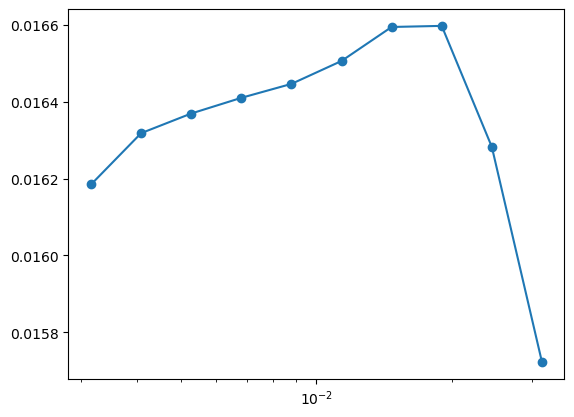

sub-01 [ 9 11 16 28 31 33 39 45 46 49]   (10)


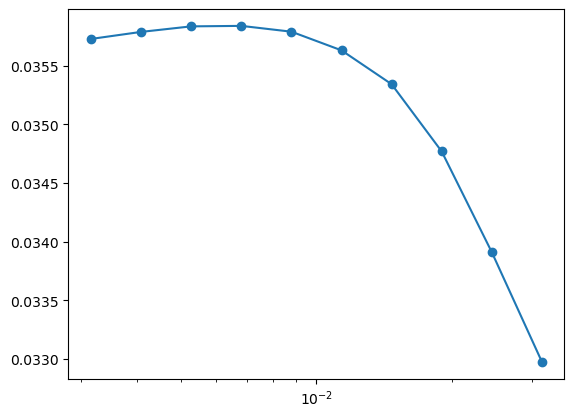

sub-02 [ 1  9 10 11 13 14 16 23 28 29 32 34 40 42 45 46 48 49]   (18)


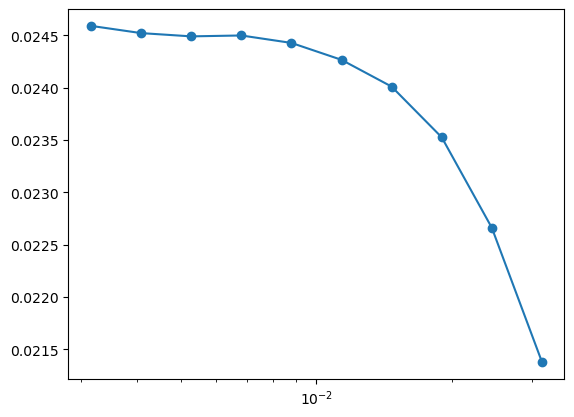

sub-03 [ 1  3  8  9 10 13 17 18 21 23 26 27 30 31 32 34 35 37 38 40 45 46 49 52
 55 58 60 61]   (28)


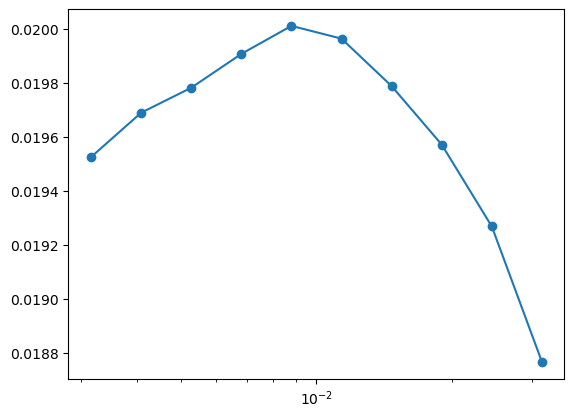

sub-04 [ 5  8  9 10 14 16 28 31 33 34 38 39 40 41 45 48 49 60]   (18)


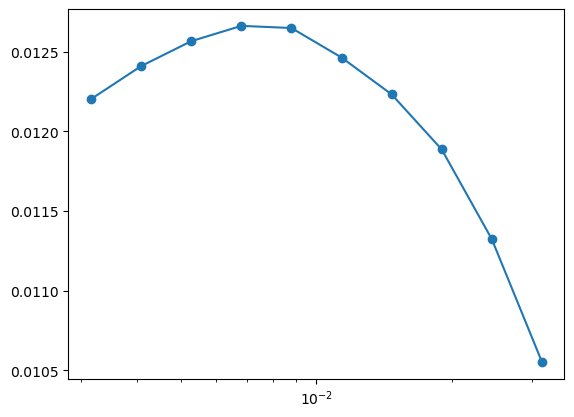

sub-05 [ 5  9 10 14 21 27 28 30 31 34 38 39 42 43 60]   (15)


In [99]:
sub = 'sub-09'#['sub-03', 'sub-08']

for sub in subs:
    train_feature = np.load(pjoin(concate_path, sub, f'{sub}_train-feature-V1.npy'), mmap_mode='r')
    train_data = np.load(pjoin(concate_path, sub, f'{sub}_train-resp-V1.npy'), mmap_mode='r')
    train_y = train_data.reshape(-1)
    N = train_feature.shape[0]
    # 生成分组标记，每4000个样本内部每1000个样本为一组
    # 这里我们假设N是4000的整数倍，每个大单元里面有4个子组
    groups = np.tile(np.repeat(np.arange(4), 1000), N // 4000)

    # 初始化GroupKFold，n_splits设置为4，因为我们想要进行4折交叉验证
    gkf = GroupKFold(n_splits=4)
    alphas = np.logspace(-3.5,-2,10)
    scores = []
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        cv_scores = cross_val_score(lasso, train_feature, train_y, scoring='r2', cv=gkf, groups=groups)
        scores.append(np.mean(cv_scores))

    plt.style.use('default')
    plt.plot(alphas,scores, marker='o')
    plt.xscale('log')
    plt.savefig(pjoin(performance_path, f'{sub}-lasso-valr2.jpg'))
    plt.close()

    max_alpha = alphas[np.argmax(scores)]
    lasso = Lasso(alpha=max_alpha)
    lasso.fit(train_feature, train_y)
    # joblib.dump(lasso, pjoin(performance_path, f'{sub}_lasso.pkl'))
    # lasso.score(train_feature, train_y)
    print(sub, np.where(lasso.coef_!=0)[0], f'  ({len(np.where(lasso.coef_!=0)[0])})')
    # test_feature = np.load(pjoin(concate_path, sub, f'{sub}_test-feature-V1.npy'), mmap_mode='r')
    # test_data = np.load(pjoin(concate_path, sub, f'{sub}_test-resp-V1.npy'), mmap_mode='r')
    # train_y = train_data.reshape(-1)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.922e+05, tolerance: 2.217e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.010e+05, tolerance: 2.217e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

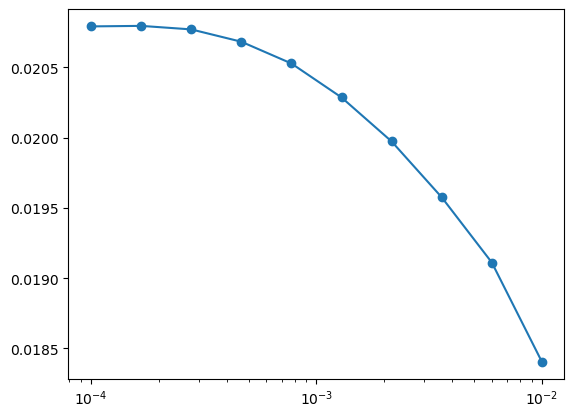

/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e+05, tolerance: 2.956e+02
  model = cd_fast.enet_coordinate_descent(


sub-01 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 54 55 56 57 58 59 60 61 62]   (60)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.122e+05, tolerance: 2.259e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.341e+05, tolerance: 2.259e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

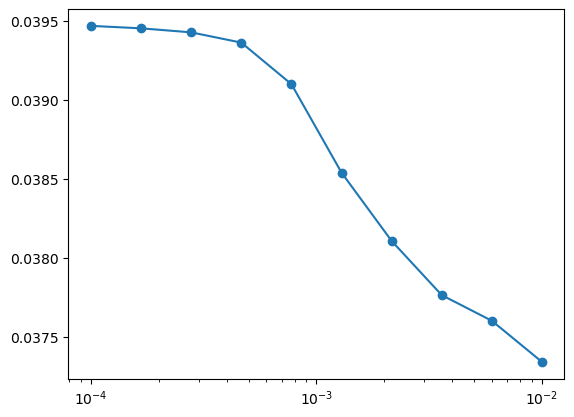

/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.094e+05, tolerance: 3.012e+02
  model = cd_fast.enet_coordinate_descent(


sub-02 [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 18 19 20 21 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62]   (60)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.521e+05, tolerance: 2.313e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+05, tolerance: 2.313e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

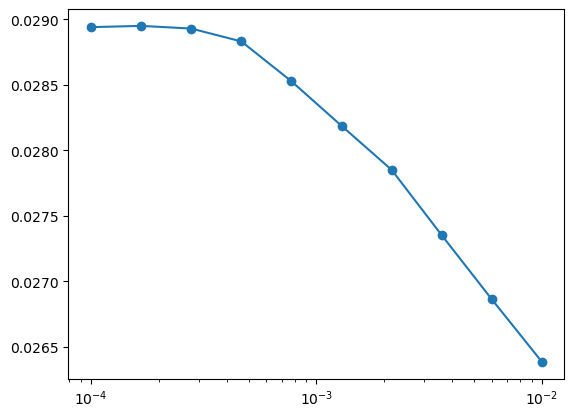

/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+05, tolerance: 3.084e+02
  model = cd_fast.enet_coordinate_descent(


sub-03 [ 1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62]   (60)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e+05, tolerance: 2.505e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.506e+05, tolerance: 2.505e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

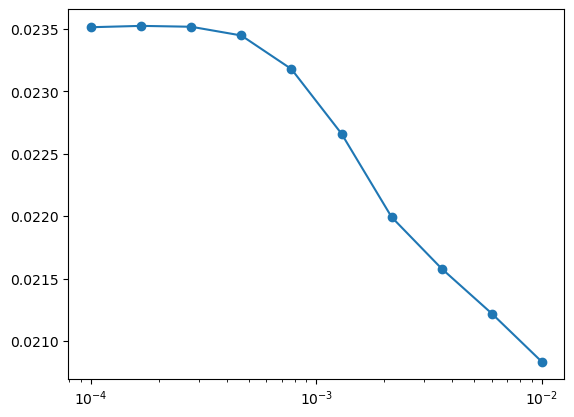

/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.595e+04, tolerance: 3.340e+02
  model = cd_fast.enet_coordinate_descent(


sub-04 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62]   (62)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.359e+04, tolerance: 1.992e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.023e+04, tolerance: 1.992e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

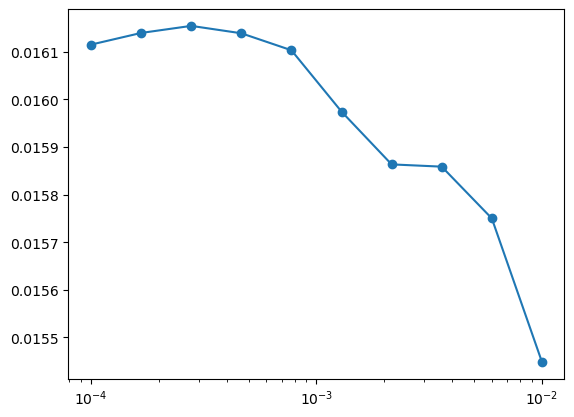

/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e+03, tolerance: 2.656e+02
  model = cd_fast.enet_coordinate_descent(


sub-05 [ 1  5  6  7  8  9 10 11 12 14 15 16 17 18 20 21 22 23 24 26 27 28 29 30
 31 32 34 35 36 37 38 40 41 42 43 44 45 46 47 48 49 50 51 52 53 55 56 57
 58 59 60 62]   (52)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.147e+05, tolerance: 1.947e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e+05, tolerance: 1.947e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

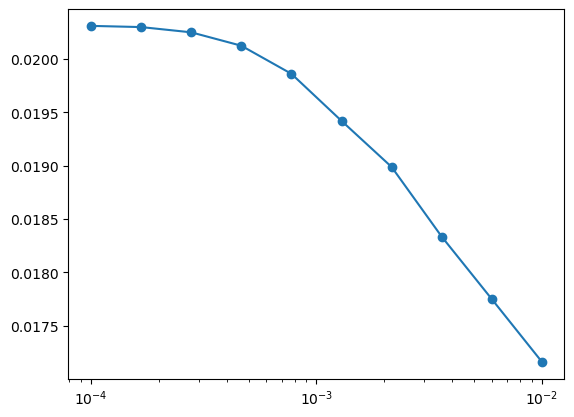

/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.578e+04, tolerance: 2.596e+02
  model = cd_fast.enet_coordinate_descent(


sub-06 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 54 55 56 57 58 59 60 61 62]   (62)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.265e+04, tolerance: 2.073e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.705e+05, tolerance: 2.073e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

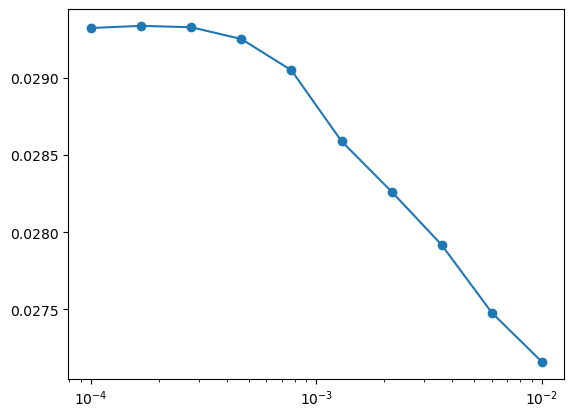

/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e+05, tolerance: 2.764e+02
  model = cd_fast.enet_coordinate_descent(


sub-07 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62]   (61)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e+05, tolerance: 2.301e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e+05, tolerance: 2.301e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

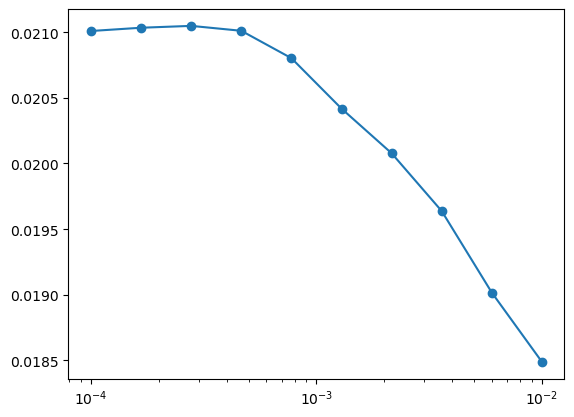

/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.745e+02, tolerance: 3.068e+02
  model = cd_fast.enet_coordinate_descent(


sub-08 [ 0  1  2  3  4  5  6  8 10 11 12 13 14 15 16 17 18 19 20 21 23 24 26 27
 28 29 30 31 32 33 34 35 36 37 38 40 41 42 45 46 47 48 49 50 51 52 53 54
 55 56 58 60 61 62]   (54)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.246e+05, tolerance: 2.364e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+05, tolerance: 2.364e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

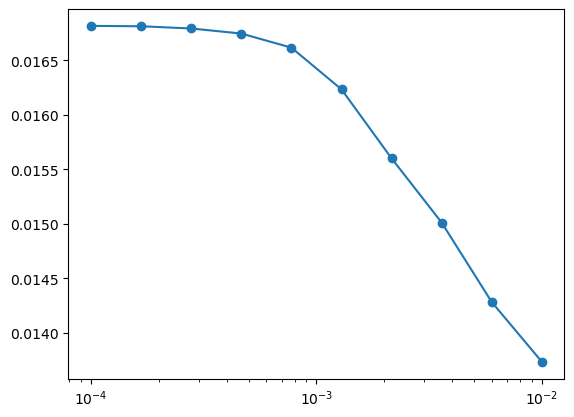

sub-09 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 57 58 59 60 61 62]   (61)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.512e+05, tolerance: 3.152e+02
  model = cd_fast.enet_coordinate_descent(


In [136]:
sub = 'sub-09'#['sub-03', 'sub-08']

for sub in subs:
    train_feature = np.load(pjoin(concate_path, sub, f'{sub}_train-feature-V1.npy'), mmap_mode='r')
    train_data = np.load(pjoin(concate_path, sub, f'{sub}_train-resp-V1.npy'), mmap_mode='r')
    train_y = train_data.reshape(-1)

    # 初始化GroupKFold，n_splits设置为4，因为我们想要进行4折交叉验证
    kf = KFold(n_splits=4)
    alphas = np.logspace(-4,-2,10)
    scores = []
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        cv_scores = cross_val_score(lasso, train_feature, train_y, scoring='r2', cv=kf)
        scores.append(np.mean(cv_scores))

    plt.style.use('default')
    plt.plot(alphas,scores, marker='o')
    plt.xscale('log')
    plt.show()
    # plt.savefig(pjoin(performance_path, f'{sub}-lasso-valr2.jpg'))
    # plt.close()

    max_alpha = alphas[np.argmax(scores)]
    lasso = Lasso(alpha=max_alpha)
    lasso.fit(train_feature, train_y)
    # joblib.dump(lasso, pjoin(performance_path, f'{sub}_lasso.pkl'))
    # lasso.score(train_feature, train_y)
    print(sub, np.where(lasso.coef_!=0)[0], f'  ({len(np.where(lasso.coef_!=0)[0])})')
    # test_feature = np.load(pjoin(concate_path, sub, f'{sub}_test-feature-V1.npy'), mmap_mode='r')
    # test_data = np.load(pjoin(concate_path, sub, f'{sub}_test-resp-V1.npy'), mmap_mode='r')
    # train_y = train_data.reshape(-1)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.571e+05, tolerance: 2.364e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.643e+05, tolerance: 2.364e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

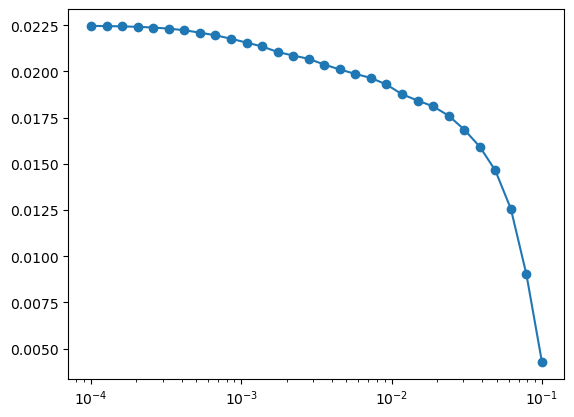

alpha: 0.0001  at  0


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.575e+05, tolerance: 2.956e+02
  model = cd_fast.enet_coordinate_descent(


sub-01 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62]   (61)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.857e+05, tolerance: 2.408e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.167e+05, tolerance: 2.408e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

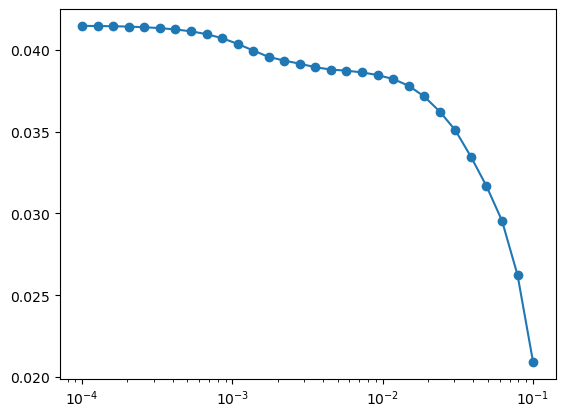

alpha: 0.0001  at  0


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.094e+05, tolerance: 3.012e+02
  model = cd_fast.enet_coordinate_descent(


sub-02 [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 18 19 20 21 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62]   (60)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.594e+05, tolerance: 2.464e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.931e+05, tolerance: 2.468e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

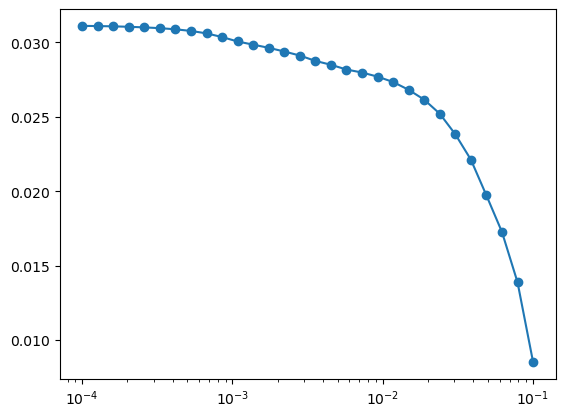

alpha: 0.0001  at  0


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e+05, tolerance: 3.084e+02
  model = cd_fast.enet_coordinate_descent(


sub-03 [ 1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62]   (61)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.519e+05, tolerance: 2.672e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+05, tolerance: 2.672e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

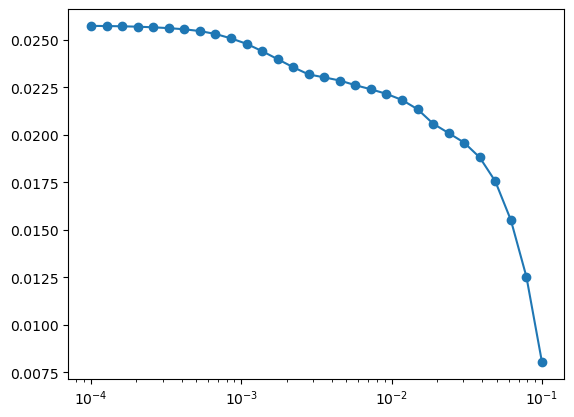

alpha: 0.0001  at  0


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.461e+05, tolerance: 3.340e+02
  model = cd_fast.enet_coordinate_descent(


sub-04 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]   (63)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.291e+04, tolerance: 2.124e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.057e+05, tolerance: 2.124e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

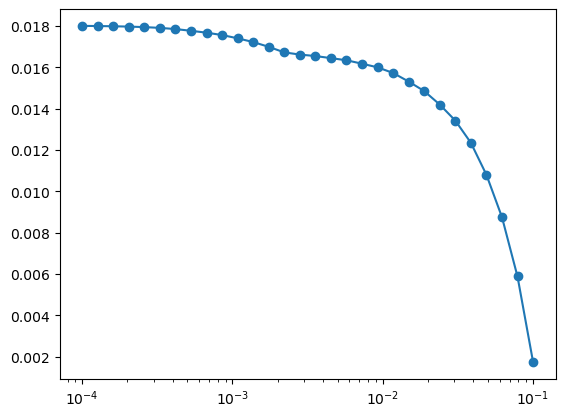

alpha: 0.0001  at  0


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.106e+05, tolerance: 2.656e+02
  model = cd_fast.enet_coordinate_descent(


sub-05 [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62]   (60)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.883e+04, tolerance: 2.076e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.194e+05, tolerance: 2.076e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

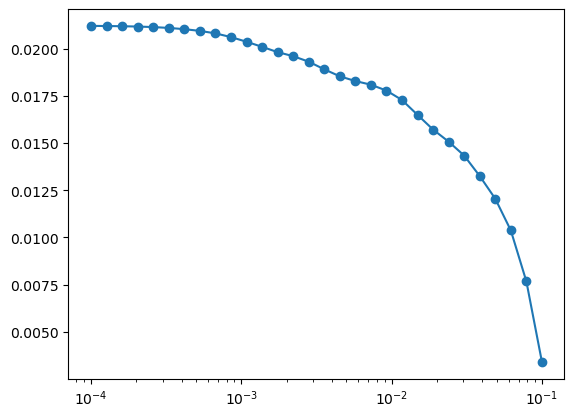

alpha: 0.0001  at  0


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.578e+04, tolerance: 2.596e+02
  model = cd_fast.enet_coordinate_descent(


sub-06 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 54 55 56 57 58 59 60 61 62]   (62)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e+05, tolerance: 2.208e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.511e+05, tolerance: 2.212e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

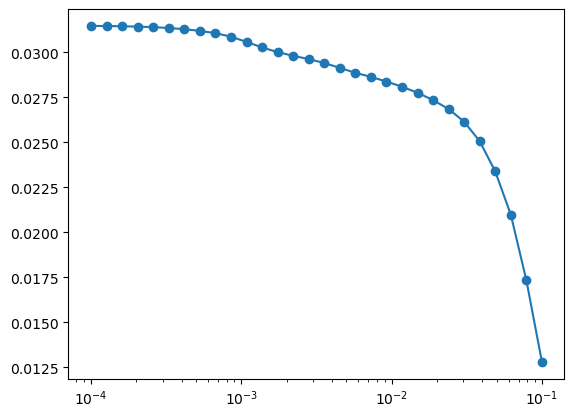

alpha: 0.0001  at  0


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.316e+05, tolerance: 2.764e+02
  model = cd_fast.enet_coordinate_descent(


sub-07 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62]   (61)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.180e+05, tolerance: 2.452e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.591e+05, tolerance: 2.452e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

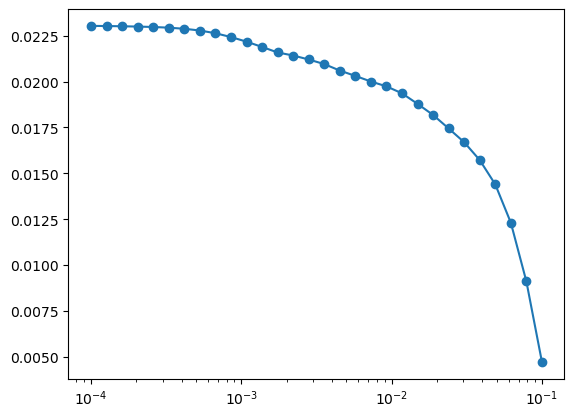

alpha: 0.0001  at  0


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.739e+05, tolerance: 3.068e+02
  model = cd_fast.enet_coordinate_descent(


sub-08 [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62]   (59)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.061e+05, tolerance: 2.520e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e+05, tolerance: 2.520e+02
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

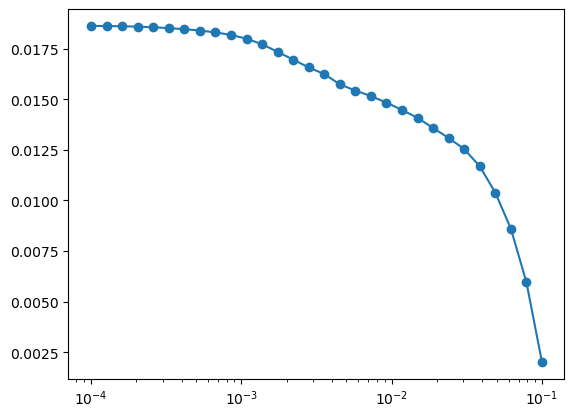

alpha: 0.0001  at  0
sub-09 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 57 58 59 60 61 62]   (61)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.512e+05, tolerance: 3.152e+02
  model = cd_fast.enet_coordinate_descent(


In [139]:
for sub in subs:
    train_feature = np.load(pjoin(concate_path, sub, f'{sub}_train-feature-V1.npy'), mmap_mode='r')
    train_data = np.load(pjoin(concate_path, sub, f'{sub}_train-resp-V1.npy'), mmap_mode='r')
    train_y = train_data.reshape(-1)

    # 初始化GroupKFold，n_splits设置为4，因为我们想要进行4折交叉验证
    # 假设total_samples和samples_per_group已经定义
    total_samples = train_feature.shape[0]
    samples_per_group = 4000
    num_groups = int(total_samples / samples_per_group)

    # 创建一个数组，表示每个样本的组ID
    group_array = np.repeat(np.arange(num_groups), samples_per_group)

    # 初始化GroupKFold，这里设置n_splits=5进行5折交叉验证
    gkf = GroupKFold(n_splits=5)
    alphas = np.logspace(-4,-1,30)
    scores = []
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        cv_scores = cross_val_score(lasso, train_feature, train_y, scoring='r2', cv=gkf, groups=group_array)
        scores.append(np.mean(cv_scores))

    plt.style.use('default')
    plt.plot(alphas,scores, marker='o')
    plt.xscale('log')
    plt.show()
    # plt.savefig(pjoin(performance_path, f'{sub}-lasso-valr2.jpg'))
    # plt.close()

    max_alpha = alphas[np.argmax(scores)]
    print('alpha:', max_alpha, ' at ', np.argmax(scores))
    lasso = Lasso(alpha=max_alpha)
    lasso.fit(train_feature, train_y)
    joblib.dump(lasso, pjoin(performance_path, f'{sub}_lasso-crossvox.pkl'))
    # lasso.score(train_feature, train_y)
    print(sub, np.where(lasso.coef_!=0)[0], f'  ({len(np.where(lasso.coef_!=0)[0])})')
    # test_feature = np.load(pjoin(concate_path, sub, f'{sub}_test-feature-V1.npy'), mmap_mode='r')
    # test_data = np.load(pjoin(concate_path, sub, f'{sub}_test-resp-V1.npy'), mmap_mode='r')
    # test_y = test_data.reshape(-1)


#### lasso performance

In [ ]:
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr
def pearson_correlation(y_true, y_pred):
    # 确保输入是NumPy数组
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # 确保输入是一维的
    if y_true.ndim > 1:
        y_true = np.ravel(y_true)
    if y_pred.ndim > 1:
        y_pred = np.ravel(y_pred)
    
    # 移除NaN值
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    # 计算并返回皮尔森相关系数
    return pearsonr(y_true, y_pred)[0]

val_scores, val_corrs = [], []
test_scores, test_corrs = [], []
for sub in subs:
    os.makedirs(pjoin(performance_path, sub), exist_ok=True)
    print('loading train features ')
    # training feature and response
    train_feature = np.load(pjoin(concate_path, sub, f'{sub}_train-feature-V1.npy'), mmap_mode='r')
    train_data = np.load(pjoin(concate_path, sub, f'{sub}_train-resp-V1.npy'), mmap_mode='r')
    train_y = train_data.reshape(-1)
    print('loading test features ')
    # test feature and response
    test_feature = np.load(pjoin(concate_path, sub, f'{sub}_test-feature-V1.npy'), mmap_mode='r')
    test_data = np.load(pjoin(concate_path, sub, f'{sub}_test-resp-V1.npy'), mmap_mode='r')
    test_y = test_data.reshape(-1)
    
    N = train_feature.shape[0]
    # 生成分组标记，每4000个样本内部每1000个样本为一组
    # 这里我们假设N是4000的整数倍，每个大单元里面有4个子组
    groups = np.tile(np.repeat(np.arange(4), 1000), N // 4000)

    # load lasso model
    print('loading lasso model')
    lasso = joblib.load(pjoin(performance_path, 'V1', f'{sub}_lasso.pkl'))
    max_alpha = lasso.alpha

    # 初始化GroupKFold，n_splits设置为4，因为我们想要进行4折交叉验证
    gkf = GroupKFold(n_splits=4)
    vallasso = Lasso(alpha=max_alpha)

    cv_scores = cross_val_score(vallasso, train_feature, train_y, scoring='r2', cv=gkf, groups=groups)
    val_scores.append(np.mean(cv_scores))

    pearson_scorer = make_scorer(pearson_correlation, greater_is_better=True)
    cv_scores = cross_val_score(vallasso, train_feature, train_y, scoring=pearson_scorer,  cv=gkf, groups=groups)
    val_corrs.append(np.mean(cv_scores))

    y_pred = lasso.predict(test_feature)
    # 计算并记录性能指标
    test_corrs.append(np.corrcoef(test_y, y_pred)[0,1])
    test_scores.append(lasso.score(test_feature, test_y))

    print(sub, np.where(lasso.coef_!=0)[0], f'  ({len(np.where(lasso.coef_!=0)[0])})')
np.save(pjoin(performance_path, f'all-sub_model-lasso_V1_validation-corr.npy'), np.array(val_corrs))
np.save(pjoin(performance_path, f'all-sub_model-lasso_V1_validation-expvar.npy'), np.array(val_scores))
np.save(pjoin(performance_path, f'all-sub_model-lasso_V1_test-corr.npy'), np.array(test_corrs))
np.save(pjoin(performance_path, f'all-sub_model-lasso_V1_test-expvar.npy'), np.array(test_scores))



#### linear performance

In [2]:
# 抽一个nsd被试
import nibabel as nib
nsdsub = nib.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/NSD-mfm/anal/brainmap/masked_retinotopy/subj01/subj01_masked-dnn-prf.dscalar.nii').get_fdata()


In [3]:
nsdv1 = [_ for _ in np.where(np.isnan(nsdsub[3,:])!=1)[0] if _ in np.where(get_roi_data(None, 'V1')==1)[0]]

In [ ]:
smallerv1 = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/roi-voxel-concate/center-vis-area/sub-01/sub-01_voxel-V1.npy')

In [18]:
# 读取V1的索引和体素编号, 看看中央视野的体素各有多少
map_dir = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
sub = 'sub-01'
for sub in subs:
    voxels = np.load(pjoin(concate_path, sub, f'{sub}_voxel-V1.npy'))
    dnnecc = nib.load(pjoin(map_dir, sub, f'{sub}_masked-dnn-prf.dscalar.nii')).get_fdata()[0,:]
    selected_voxels = [ _ for _ in np.where(dnnecc<3)[0] if _ in np.squeeze(voxels)]
    print(sub, len(selected_voxels))

sub-01 392
sub-02 386
sub-03 386
sub-04 382
sub-05 264
sub-06 286
sub-07 329
sub-08 373
sub-09 479


#### full-valid-V1 training

In [8]:
#
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr
def pearson_correlation(y_true, y_pred):
    # 确保输入是NumPy数组
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # 确保输入是一维的
    if y_true.ndim > 1:
        y_true = np.ravel(y_true)
    if y_pred.ndim > 1:
        y_pred = np.ravel(y_pred)
    
    # 移除NaN值
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    # 计算并返回皮尔森相关系数
    return pearsonr(y_true, y_pred)[0]

for roi_name in ['V4']:#'V2', 'V3', 
    val_scores, val_corrs = [], []
    test_scores, test_corrs = [], []
    # roi_name = 'V1'
    for sub in subs:
        os.makedirs(pjoin(performance_path, roi_name), exist_ok=True)
        print('loading train features ')
        # training feature and response
        train_feature = np.load(pjoin(concate_path, sub, f'{sub}_train-feature-{roi_name}.npy'), mmap_mode='r')
        train_data = np.load(pjoin(concate_path, sub, f'{sub}_train-resp-{roi_name}.npy'), mmap_mode='r')
        train_y = train_data.reshape(-1)
        print('loading test features ')
        # test feature and response
        test_feature = np.load(pjoin(concate_path, sub, f'{sub}_test-feature-{roi_name}.npy'), mmap_mode='r')
        test_data = np.load(pjoin(concate_path, sub, f'{sub}_test-resp-{roi_name}.npy'), mmap_mode='r')
        test_y = test_data.reshape(-1)
        
        N = train_feature.shape[0]
        # 生成分组标记，每4000个样本内部每1000个样本为一组
        # 这里我们假设N是4000的整数倍，每个大单元里面有4个子组
        groups = np.tile(np.repeat(np.arange(4), 1000), N // 4000)

        # training linear model
        lr = LinearRegression(n_jobs=10)
        lr.fit(train_feature, train_y)
        joblib.dump(lr, pjoin(performance_path, roi_name, f'{sub}_{roi_name}-linear.pkl'))
        
        # 初始化GroupKFold，n_splits设置为4，因为我们想要进行4折交叉验证
        gkf = GroupKFold(n_splits=4)
        vallr = LinearRegression(n_jobs=10)

        cv_scores = cross_val_score(vallr, train_feature, train_y, scoring='r2', cv=gkf, groups=groups)
        val_scores.append(np.mean(cv_scores))

        pearson_scorer = make_scorer(pearson_correlation, greater_is_better=True)
        cv_scores = cross_val_score(vallr, train_feature, train_y, scoring=pearson_scorer,  cv=gkf, groups=groups)
        val_corrs.append(np.mean(cv_scores))

        y_pred = lr.predict(test_feature)
        # 计算并记录性能指标
        test_corrs.append(np.corrcoef(test_y, y_pred)[0,1])
        test_scores.append(lr.score(test_feature, test_y))

        print(sub, 'finished')
    np.save(pjoin(performance_path,  f'all-sub_model-linear_{roi_name}_validation-corr.npy'), np.array(val_corrs))
    np.save(pjoin(performance_path,  f'all-sub_model-linear_{roi_name}_validation-expvar.npy'), np.array(val_scores))
    np.save(pjoin(performance_path,  f'all-sub_model-linear_{roi_name}_test-corr.npy'), np.array(test_corrs))
    np.save(pjoin(performance_path,  f'all-sub_model-linear_{roi_name}_test-expvar.npy'), np.array(test_scores))




loading train features 
loading test features 
sub-01 finished
loading train features 
loading test features 
sub-02 finished
loading train features 
loading test features 
sub-03 finished
loading train features 
loading test features 
sub-04 finished
loading train features 
loading test features 
sub-05 finished
loading train features 
loading test features 
sub-06 finished
loading train features 
loading test features 
sub-07 finished
loading train features 
loading test features 
sub-08 finished
loading train features 
loading test features 
sub-09 finished


#### selected-V1 training

In [2]:
# train smaller V1 to compare with nsd
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr
def pearson_correlation(y_true, y_pred):
    # 确保输入是NumPy数组
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # 确保输入是一维的
    if y_true.ndim > 1:
        y_true = np.ravel(y_true)
    if y_pred.ndim > 1:
        y_pred = np.ravel(y_pred)
    
    # 移除NaN值
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    # 计算并返回皮尔森相关系数
    return pearsonr(y_true, y_pred)[0]

val_scores, val_corrs = [], []
test_scores, test_corrs = [], []
roi_name = 'V1'
for sub in subs:
    os.makedirs(pjoin(performance_path, f'smaller-{roi_name}'), exist_ok=True)
    print('loading train features ')
    # training feature and response
    train_feature = np.load(pjoin(concate_path, 'center-vis-area', sub, f'{sub}_train-feature-V1.npy'), mmap_mode='r')
    train_data = np.load(pjoin(concate_path, 'center-vis-area', sub, f'{sub}_train-resp-V1.npy'), mmap_mode='r')
    train_y = train_data.reshape(-1)
    print('loading test features ')
    # test feature and response
    test_feature = np.load(pjoin(concate_path, 'center-vis-area', sub, f'{sub}_test-feature-V1.npy'), mmap_mode='r')
    test_data = np.load(pjoin(concate_path,  'center-vis-area', sub, f'{sub}_test-resp-V1.npy'), mmap_mode='r')
    test_y = test_data.reshape(-1)
    
    N = train_feature.shape[0]
    # 生成分组标记，每4000个样本内部每1000个样本为一组
    # 这里我们假设N是4000的整数倍，每个大单元里面有4个子组
    groups = np.tile(np.repeat(np.arange(4), 1000), N // 4000)

    # training linear model
    lr = LinearRegression(n_jobs=10)
    lr.fit(train_feature, train_y)
    joblib.dump(lr, pjoin(performance_path, f'smaller-{roi_name}', f'{sub}_linear.pkl'))
    
    # 初始化GroupKFold，n_splits设置为4，因为我们想要进行4折交叉验证
    gkf = GroupKFold(n_splits=4)
    vallr = LinearRegression(n_jobs=10)

    cv_scores = cross_val_score(vallr, train_feature, train_y, scoring='r2', cv=gkf, groups=groups)
    val_scores.append(np.mean(cv_scores))

    pearson_scorer = make_scorer(pearson_correlation, greater_is_better=True)
    cv_scores = cross_val_score(vallr, train_feature, train_y, scoring=pearson_scorer,  cv=gkf, groups=groups)
    val_corrs.append(np.mean(cv_scores))

    y_pred = lr.predict(test_feature)
    # 计算并记录性能指标
    test_corrs.append(np.corrcoef(test_y, y_pred)[0,1])
    test_scores.append(lr.score(test_feature, test_y))

    print(sub, f'finished, cor {test_corrs[-1]}, {val_corrs[-1]} | expvar {test_scores[-1]}, {val_scores[-1]} ')
# np.save(pjoin(performance_path,  f'all-sub_model-linear_{roi_name}_validation-corr.npy'), np.array(val_corrs))
# np.save(pjoin(performance_path,  f'all-sub_model-linear_{roi_name}_validation-expvar.npy'), np.array(val_scores))
# np.save(pjoin(performance_path,  f'all-sub_model-linear_{roi_name}_test-corr.npy'), np.array(test_corrs))
# np.save(pjoin(performance_path,  f'all-sub_model-linear_{roi_name}_test-expvar.npy'), np.array(test_scores))



The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-790334219530>", line 26, in <module>
    for sub in subs:
NameError: name 'subs' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2045, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1170, in get_records
    return _fixed_getinnerframes(etb, n

In [ ]:
# 在每个分隔开的 EA grid 体素上训练线性模型
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr

def pearson_correlation(y_true, y_pred):
    # 确保输入是NumPy数组
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # 确保输入是一维的
    if y_true.ndim > 1:
        y_true = np.ravel(y_true)
    if y_pred.ndim > 1:
        y_pred = np.ravel(y_pred)
    
    # 移除NaN值
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    # 计算并返回皮尔森相关系数
    return pearsonr(y_true, y_pred)[0]

quater_names = [f'E{_}A{__}' for _ in range(4) for __ in range(4)]

for quater_name in quater_names:
    val_scores, val_corrs = [], []
    test_scores, test_corrs = [], []
    roi_name = 'V1'
    logs = []
    for sub in subs:
        os.makedirs(pjoin(performance_path, 'retinogrid', quater_name), exist_ok=True)
        print('loading train features ')
        # training feature and response
        train_feature = np.load(pjoin(concate_path, 'retinogrid', quater_name, sub, f'{sub}_train-feature-{roi_name}.npy'), mmap_mode='r')
        train_data = np.load(pjoin(concate_path, 'retinogrid', quater_name, sub, f'{sub}_train-resp-{roi_name}.npy'), mmap_mode='r')
        train_y = train_data.reshape(-1)
        print('loading test features ')
        # test feature and response
        test_feature = np.load(pjoin(concate_path, 'retinogrid', quater_name, sub, f'{sub}_test-feature-{roi_name}.npy'), mmap_mode='r')
        test_data = np.load(pjoin(concate_path, 'retinogrid', quater_name, sub, f'{sub}_test-resp-{roi_name}.npy'), mmap_mode='r')
        test_y = test_data.reshape(-1)
        
        N = train_feature.shape[0]
        # 生成分组标记，每4000个样本内部每1000个样本为一组
        # 这里我们假设N是4000的整数倍，每个大单元里面有4个子组
        groups = np.tile(np.repeat(np.arange(4), 1000), N // 4000)

        # training linear model
        lr = LinearRegression(n_jobs=10)
        lr.fit(train_feature, train_y)
        joblib.dump(lr, pjoin(performance_path, 'retinogrid', quater_name, f'{sub}_{roi_name}-linear.pkl'))
        
        # 初始化GroupKFold，n_splits设置为4，因为我们想要进行4折交叉验证
        gkf = GroupKFold(n_splits=4)
        vallr = LinearRegression(n_jobs=10)

        cv_scores = cross_val_score(vallr, train_feature, train_y, scoring='r2', cv=gkf, groups=groups)
        val_scores.append(np.mean(cv_scores))

        pearson_scorer = make_scorer(pearson_correlation, greater_is_better=True)
        cv_scores = cross_val_score(vallr, train_feature, train_y, scoring=pearson_scorer,  cv=gkf, groups=groups)
        val_corrs.append(np.mean(cv_scores))

        y_pred = lr.predict(test_feature)
        # 计算并记录性能指标
        test_corrs.append(np.corrcoef(test_y, y_pred)[0,1])
        test_scores.append(lr.score(test_feature, test_y))
        logs.append(f'{sub}, {roi_name}, {quater_name}, cor, {test_corrs[-1]}, {val_corrs[-1]}, |, expvar, {test_scores[-1]}, {val_scores[-1]} ')
        print(quater_name, sub, f'finished, cor, {test_corrs[-1]}, {val_corrs[-1]}, |, expvar, {test_scores[-1]}, {val_scores[-1]} ')
    with open(pjoin(performance_path, 'retinogrid', quater_name, f'sub-all_{roi_name}_perf.csv'), 'w') as f:
        logs = [log+'\n' for log in logs]
        f.writelines(logs)

In [ ]:
# 在每个分隔开的ecc体素上训练线性模型
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr

def pearson_correlation(y_true, y_pred):
    # 确保输入是NumPy数组
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # 确保输入是一维的
    if y_true.ndim > 1:
        y_true = np.ravel(y_true)
    if y_pred.ndim > 1:
        y_pred = np.ravel(y_pred)
    
    # 移除NaN值
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    # 计算并返回皮尔森相关系数
    return pearsonr(y_true, y_pred)[0]

quater_names = [f'ecc-quater{_+1}' for _ in range(4)]
for roi_name in ['V2', 'V3', 'V4']:
    for quater_name in quater_names:
        val_scores, val_corrs = [], []
        test_scores, test_corrs = [], []
        # roi_name = 'V1'
        logs = []
        for sub in subs:
            os.makedirs(pjoin(performance_path, quater_name), exist_ok=True)
            print('loading train features ')
            # training feature and response
            train_feature = np.load(pjoin(concate_path, quater_name, sub, f'{sub}_train-feature-{roi_name}.npy'), mmap_mode='r')
            train_data = np.load(pjoin(concate_path, quater_name, sub, f'{sub}_train-resp-{roi_name}.npy'), mmap_mode='r')
            train_y = train_data.reshape(-1)
            print('loading test features ')
            # test feature and response
            test_feature = np.load(pjoin(concate_path, quater_name, sub, f'{sub}_test-feature-{roi_name}.npy'), mmap_mode='r')
            test_data = np.load(pjoin(concate_path, quater_name, sub, f'{sub}_test-resp-{roi_name}.npy'), mmap_mode='r')
            test_y = test_data.reshape(-1)
            
            N = train_feature.shape[0]
            # 生成分组标记，每4000个样本内部每1000个样本为一组
            # 这里我们假设N是4000的整数倍，每个大单元里面有4个子组
            groups = np.tile(np.repeat(np.arange(4), 1000), N // 4000)

            # training linear model
            lr = LinearRegression(n_jobs=10)
            lr.fit(train_feature, train_y)
            joblib.dump(lr, pjoin(performance_path, quater_name, f'{sub}_{roi_name}-linear.pkl'))
            
            # 初始化GroupKFold，n_splits设置为4，因为我们想要进行4折交叉验证
            gkf = GroupKFold(n_splits=4)
            vallr = LinearRegression(n_jobs=10)

            cv_scores = cross_val_score(vallr, train_feature, train_y, scoring='r2', cv=gkf, groups=groups)
            val_scores.append(np.mean(cv_scores))

            pearson_scorer = make_scorer(pearson_correlation, greater_is_better=True)
            cv_scores = cross_val_score(vallr, train_feature, train_y, scoring=pearson_scorer,  cv=gkf, groups=groups)
            val_corrs.append(np.mean(cv_scores))

            y_pred = lr.predict(test_feature)
            # 计算并记录性能指标
            test_corrs.append(np.corrcoef(test_y, y_pred)[0,1])
            test_scores.append(lr.score(test_feature, test_y))
            logs.append(f'{sub}, {roi_name}, cor, {test_corrs[-1]}, {val_corrs[-1]}, |, expvar, {test_scores[-1]}, {val_scores[-1]} ')
            print(roi_name, quater_name, sub, f'finished, cor, {test_corrs[-1]}, {val_corrs[-1]}, |, expvar, {test_scores[-1]}, {val_scores[-1]} ')
        with open(pjoin(performance_path, quater_name, f'sub-all_{roi_name}_perf.csv'), 'w') as f:
            logs = [log+'\n' for log in logs]
            f.writelines(logs)

In [ ]:
# 在每个分隔开的ANG 体素上训练线性模型
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr

def pearson_correlation(y_true, y_pred):
    # 确保输入是NumPy数组
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # 确保输入是一维的
    if y_true.ndim > 1:
        y_true = np.ravel(y_true)
    if y_pred.ndim > 1:
        y_pred = np.ravel(y_pred)
    
    # 移除NaN值
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    # 计算并返回皮尔森相关系数
    return pearsonr(y_true, y_pred)[0]

quater_names = [f'ang-quater{_+1}' for _ in range(8)]

for quater_name in quater_names:
    val_scores, val_corrs = [], []
    test_scores, test_corrs = [], []
    roi_name = 'V1'
    logs = []
    for sub in subs:
        os.makedirs(pjoin(performance_path, quater_name), exist_ok=True)
        print('loading train features ')
        # training feature and response
        train_feature = np.load(pjoin(concate_path, quater_name, sub, f'{sub}_train-feature-V1.npy'), mmap_mode='r')
        train_data = np.load(pjoin(concate_path, quater_name, sub, f'{sub}_train-resp-V1.npy'), mmap_mode='r')
        train_y = train_data.reshape(-1)
        print('loading test features ')
        # test feature and response
        test_feature = np.load(pjoin(concate_path, quater_name, sub, f'{sub}_test-feature-V1.npy'), mmap_mode='r')
        test_data = np.load(pjoin(concate_path, quater_name, sub, f'{sub}_test-resp-V1.npy'), mmap_mode='r')
        test_y = test_data.reshape(-1)
        
        N = train_feature.shape[0]
        # 生成分组标记，每4000个样本内部每1000个样本为一组
        # 这里我们假设N是4000的整数倍，每个大单元里面有4个子组
        groups = np.tile(np.repeat(np.arange(4), 1000), N // 4000)

        # training linear model
        lr = LinearRegression(n_jobs=10)
        lr.fit(train_feature, train_y)
        joblib.dump(lr, pjoin(performance_path, quater_name, f'{sub}_{roi_name}-linear.pkl'))
        
        # 初始化GroupKFold，n_splits设置为4，因为我们想要进行4折交叉验证
        gkf = GroupKFold(n_splits=4)
        vallr = LinearRegression(n_jobs=10)

        cv_scores = cross_val_score(vallr, train_feature, train_y, scoring='r2', cv=gkf, groups=groups)
        val_scores.append(np.mean(cv_scores))

        pearson_scorer = make_scorer(pearson_correlation, greater_is_better=True)
        cv_scores = cross_val_score(vallr, train_feature, train_y, scoring=pearson_scorer,  cv=gkf, groups=groups)
        val_corrs.append(np.mean(cv_scores))

        y_pred = lr.predict(test_feature)
        # 计算并记录性能指标
        test_corrs.append(np.corrcoef(test_y, y_pred)[0,1])
        test_scores.append(lr.score(test_feature, test_y))
        logs.append(f'{sub}, {roi_name},cor, {test_corrs[-1]}, {val_corrs[-1]}, |, expvar, {test_scores[-1]}, {val_scores[-1]} ')
        print(quater_name, sub, f'finished, cor, {test_corrs[-1]}, {val_corrs[-1]}, |, expvar, {test_scores[-1]}, {val_scores[-1]} ')
    with open(pjoin(performance_path, quater_name, 'sub-all_V1_perf.csv'), 'w') as f:
        logs = [log+'\n' for log in logs]
        f.writelines(logs)

#### lasso fit

### 一些破旧代码

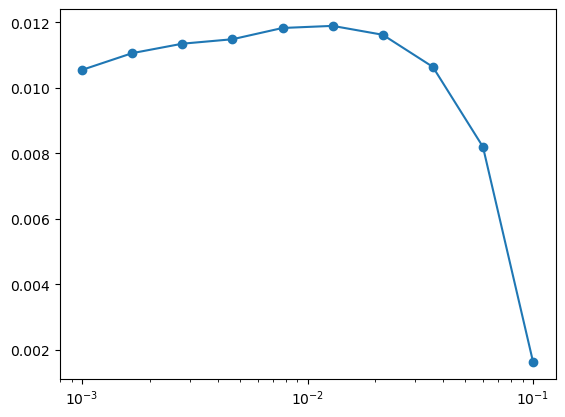

In [86]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.plot(alphas,scores, marker='o')
plt.xscale('log')

In [24]:
def extract_v2_features(featurename):
    _features = []
    for result in resultdicts:
        if result['voxel'] in v2_voxels:
            _features.append(result[featurename])
    return np.vstack(_features), featurename
for features_tuple in map(extract_v2_features, ['train-feature', 'test-feature', 'train-resp', 'test-resp', 'idx', 'voxel']):
    np.save(pjoin(concate_path, sub, f'{sub}_{features_tuple[1]}-V2.npy'), features_tuple[0])
    print(features_tuple[1])

train-feature
test-feature
train-resp
test-resp
idx
voxel


In [14]:
(map(lambda x: x.shape, [v1_voxels, v2_voxels, v3_voxels, v4_voxels]))

[(753,), (638,), (488,), (609,)]

In [21]:
3012000*63*4/1024/1024

723.8616943359375

#### 从线性拟合的角度，voxel concate 在一起得到的模型，应该与 平均所有体素 得到的结果是类似的
- liear 按道理应该一样
- Lasso 不确定如何

In [118]:
# 1. 先构建好平均的 特征 与 roi反应 
# roi 平均反应已经存在 mfm_locwise_fullpipeline/prep/concate_features 中，所有被试被concate在了一起
def adjust_RF(receptive_field):
    cur_receptive_field = receptive_field.copy()
    cur_receptive_field = cur_receptive_field + np.abs(np.min(cur_receptive_field, None)) + 1
    thres = np.min(cur_receptive_field) + 0.5*(np.max(cur_receptive_field) - np.min(cur_receptive_field)) # 
    cur_receptive_field[cur_receptive_field < thres] = 0
    cur_receptive_field = cur_receptive_field / (cur_receptive_field.sum() + 1e-20)

    return cur_receptive_field

def gaussian_2d(coords, A, x_0, y_0, sigma_x, sigma_y,C):
    i, j = coords
    return A * np.exp(-((i - x_0)**2 / (2 * sigma_x**2) + (j - y_0)**2 / (2 * sigma_y**2))) + C

# 1.1 组合得到平均的感受野
roi_name = 'V1'
avgrf_path = pjoin(work_dir, 'prep/image_mask')
i = np.linspace(-8., 8., layer['size'])
j = np.linspace(8., -8., layer['size'])
ii, jj = np.meshgrid(i, j)
for sub in subs:
    rf_file = f'{sub}_dnn-average-receptivefield-{roi_name}.npy' 
    if os.path.exists(pjoin(avgrf_path, rf_file)):
        continue
    # getting retinotopic voxels
    sub_prf_file = os.path.join(opendata_cifti_pth, sub, 'results/ses-prf_task-prf/ses-prf_task-prf_params.dscalar.nii')
    prf_r2 = nib.load(sub_prf_file).get_fdata()[3, :]
    r2_thres = 10
    voxel_mask = np.where(prf_r2 > r2_thres)[0]

    # select ROI names
    evc_pool = [roi_name] 
    # aggregate ROI vertices
    roi_names = [__  for _ in [evc_pool] for __ in _]
    # form ROI mask
    selection_mask = np.sum([get_roi_data(None, _) for _ in roi_names], axis=0)
    # trsnfer to indices in cifti space
    voxel_indices = [_ for _ in np.where(selection_mask==1)[0] if _ in voxel_mask]

    if 'conv1' in layername:
        guass_layername = layername.replace('conv1', 'conv2')
        guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'), allow_pickle=True)[0]
        print(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'))
    else:
        guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{layername}_Gauss.npy'), allow_pickle=True)[0]

    receptive_field = np.zeros((57, 57))
    for voxel in voxel_indices:
        params = guassparams[voxel]
        receptive_field += adjust_RF(gaussian_2d((ii, jj), *params))
        # receptive_field += 0.01 * prf_r2[voxel] * adjust_RF(gaussian_2d((i, j), *params))

    receptive_field = receptive_field / receptive_field.sum()
    np.save(pjoin(avgrf_path, rf_file), receptive_field)
    # plt.style.use('default')
    # plt.imshow(receptive_field)
    # plt.show()

In [120]:
# 1.2 存出平均特征
model_type = 'dnnrf'
roi_name = 'V1'
concate_feature_path = pjoin(work_dir, 'prep/concate_features')
feature_type = model_type.split('-')[0]
check_file = pjoin(concate_feature_path, f'cross-sub_{feature_type.lower()}_imn_conv2-{roi_name}.npy') #!
concate_X, concate_X_test = [], []
if not os.path.exists(check_file):
    for sub in subs:
        print(sub)
        # sub dir
        # average receptive field
        dnn_receptivefield = np.load(pjoin(avgrf_path, f'{sub}_dnn-average-receptivefield-{roi_name}.npy')) #!
        # load

        activations = np.load(pjoin(image_activations_path, f'{sub}_{layername}.npy'))
        coco_activations = np.load(pjoin(image_activations_path, f'{test_set_name}_{layername}.npy'))
        print(f'activations shape of {activations.shape}')

        if layername == 'googlenet-conv2':
            X = activations[:, 0:63, :, :]
            X_test = coco_activations[:, 0:63, :, :]
        else:
            X = activations
            X_test = coco_activations

        X_avg = zscore(np.sum(X * dnn_receptivefield, axis=(2,3)))
        X_test_avg = zscore(np.sum(X_test * dnn_receptivefield, axis=(2,3)))

        if model_type == 'globalmean':
            X_avg = zscore(np.mean(X, axis=(2,3)))
            X_test_avg = zscore(np.mean(X_test, axis=(2,3)))
        if model_type == 'priorRF':
            X_avg = zscore(np.mean(X * pri_receptivefield, axis=(2,3)))
            X_test_avg = zscore(np.mean(X_test * pri_receptivefield, axis=(2,3)))
        if model_type == 'priorwRF':
            X_avg = zscore(np.mean(X * pri_weightedrf, axis=(2,3)))
            X_test_avg = zscore(np.mean(X_test * pri_weightedrf, axis=(2,3)))        
        
        concate_X.append(X_avg) 
        concate_X_test.append(X_test_avg)
    print('saving out')
    np.save(pjoin(concate_feature_path, f'cross-sub_{model_type.lower()}_imn_conv2-{roi_name}.npy'), np.vstack(concate_X)) #!
    np.save(pjoin(concate_feature_path, f'cross-sub_{model_type.lower()}_coco_conv2-{roi_name}.npy'), np.vstack(concate_X_test)) #!

sub-01
activations shape of (4000, 64, 57, 57)
sub-02
activations shape of (4000, 64, 57, 57)
sub-03
activations shape of (4000, 64, 57, 57)
sub-04
activations shape of (4000, 64, 57, 57)
sub-05
activations shape of (4000, 64, 57, 57)
sub-06
activations shape of (4000, 64, 57, 57)
sub-07
activations shape of (4000, 64, 57, 57)
sub-08
activations shape of (4000, 64, 57, 57)
sub-09
activations shape of (4000, 64, 57, 57)
saving out


In [130]:
# 2. 对每个被试去做 Linear / Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso

def generate_pairs(n, step=120):
    return [(i*step, (i+1)*step) for i in range(n)]

lassofs_path = pjoin(work_dir, 'build/lasso-feature-selection')

roi_name = 'V1'

print('loading data')
concate_y = np.load(pjoin(concate_feature_path, f'cross-sub_imn_averaged-{roi_name}.npy'))
concate_y_test = np.load(pjoin(concate_feature_path, f'cross-sub_coco_averaged-{roi_name}.npy'))

feature_types = ['dnnRF']
traindata = {}
testdata = {}
for _feature in feature_types:
    traindata[_feature] = np.load(pjoin(concate_feature_path, f'cross-sub_{_feature.lower()}_imn_conv2-{roi_name}.npy'))
    testdata[_feature] = np.load(pjoin(concate_feature_path, f'cross-sub_{_feature.lower()}_coco_conv2-{roi_name}.npy'))

for feature_type in  feature_types:

    model_type = f'lasso-{feature_type}'
    os.makedirs(pjoin(lassofs_path, model_type), exist_ok=True)
    print('best feature type', feature_type)
    concate_X = traindata[feature_type]
    # test performance
    concate_X_test = testdata[feature_type]
    train_pairs = generate_pairs(9, step=4000)
    test_pairs = generate_pairs(9)
    final_test_corr, final_test_ev = [], []
    final_val_corr, final_val_ev = [], []
    final_train_corr, final_train_ev = [], []
    for ipair, train_pair in enumerate(train_pairs):

        X_train = concate_X[train_pair[0]:train_pair[1]]
        y_train = concate_y[train_pair[0]:train_pair[1]]
        print('train data shape:', X_train.shape, y_train.shape)

        sessionKf = KFold(n_splits=4, shuffle=False)
        if 'lasso' in model_type:
            # lasso模型的CV
            alphas = np.logspace(-3, -1, 30)  # 创建一个覆盖广泛范围的alpha值
            scores = []  # 用于存储每个alpha对应的平均交叉验证分数    
            # 对每个alpha进行评估
            for alpha in alphas:
                lasso = Lasso(alpha=alpha)
                cv_scores = cross_val_score(lasso, X_train, y_train, scoring='r2', cv=sessionKf)
                scores.append(np.mean(cv_scores))
            # 创建Lasso模型实例
            # print(scores)
            max_alpha = alphas[np.argmax(scores)]
            lasso = Lasso(alpha=max_alpha)
            print('sub-', (ipair+1), ' max_alpha:', max_alpha, 'at where', np.argmax(scores))

            # 存出validation的表现
            final_val_ev.append(np.mean(cross_val_score(lasso, X_train, y_train, scoring='r2', cv=sessionKf)))
            pearson_scorer = make_scorer(pearson_correlation, greater_is_better=True)
            final_val_corr.append(np.mean(cross_val_score(lasso, X_train, y_train, scoring=pearson_scorer, cv=sessionKf)))
            # 存出训练好的模型
            lasso.fit(X_train, y_train)
            joblib.dump(lasso, pjoin(lassofs_path, model_type, f'nod-within-sub-{ipair+1}_model-{model_type}_lasso.pkl'))
            # 存出 train 和 test 的表现
            y_pred = lasso.predict(X_train)
            final_train_corr.append(np.corrcoef(y_pred, y_train[:,0])[0, 1]) 
            final_train_ev.append(lasso.score(X_train, y_train)) 

            X_test = concate_X_test[test_pairs[ipair][0]:test_pairs[ipair][1]]
            y_test = concate_y_test[test_pairs[ipair][0]:test_pairs[ipair][1]]
            y_pred = lasso.predict(X_test)
            final_test_corr.append(np.corrcoef(y_pred, y_test[:,0])[0, 1])
            final_test_ev.append(lasso.score(X_test, y_test))        
        
        if 'linear' in model_type:
            # 线性模型的CV
            lr = LinearRegression(n_jobs=8)
            cv_scores = cross_val_score(lr, X_train, y_train, scoring='r2', cv=sessionKf)
            final_val_ev.append(np.mean(cv_scores))
            # corr index
            pearson_scorer = make_scorer(pearson_correlation, greater_is_better=True)
            cv_scores = cross_val_score(lr, X_train, y_train, scoring=pearson_scorer, cv=sessionKf)
            final_val_corr.append(np.mean(cv_scores))

            lr.fit(X_train, y_train)
            joblib.dump(lr, pjoin(lassofs_path, model_type, f'nod-within-sub-{ipair+1}_model-{model_type}_linear.pkl'))
            X_test = concate_X_test[test_pairs[ipair][0]:test_pairs[ipair][1]]
            y_test = concate_y_test[test_pairs[ipair][0]:test_pairs[ipair][1]]
            
            y_pred = lr.predict(X_test)
            final_test_corr.append(np.corrcoef(y_pred[:,0], y_test[:,0])[0, 1])
            final_test_ev.append(lr.score(X_test, y_test))

            y_pred = lr.predict(X_train)
            final_train_corr.append(np.corrcoef(y_pred[:,0], y_train[:,0])[0, 1])
            final_train_ev.append(lr.score(X_train, y_train))

    print('saving feature model and test performance')
    # 
    np.save(pjoin(lassofs_path, model_type, f'nod-within-sub_model-{model_type}_test-corr.npy'), np.array(final_test_corr))
    np.save(pjoin(lassofs_path, model_type, f'nod-within-sub_model-{model_type}_test-expvar.npy'), np.array(final_test_ev))
    np.save(pjoin(lassofs_path, model_type, f'nod-within-sub_model-{model_type}_train-corr.npy'), np.array(final_train_corr))
    np.save(pjoin(lassofs_path, model_type, f'nod-within-sub_model-{model_type}_train-expvar.npy'), np.array(final_train_ev))
    np.save(pjoin(lassofs_path, model_type, f'nod-within-sub_model-{model_type}_val-corr.npy'), np.array(final_val_corr))
    np.save(pjoin(lassofs_path, model_type, f'nod-within-sub_model-{model_type}_val-expvar.npy'), np.array(final_val_ev))


loading data
best feature type dnnRF
train data shape: (4000, 63) (4000, 1)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.571e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.389e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

sub- 1  max_alpha: 0.02395026619987486 at where 20
train data shape: (4000, 63) (4000, 1)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.174e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e+02, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

sub- 2  max_alpha: 0.01487352107293511 at where 17
train data shape: (4000, 63) (4000, 1)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.575e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.031e-01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

sub- 3  max_alpha: 0.005736152510448681 at where 11
train data shape: (4000, 63) (4000, 1)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.983e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

sub- 4  max_alpha: 0.020433597178569417 at where 19
train data shape: (4000, 63) (4000, 1)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.985e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.541e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

sub- 5  max_alpha: 0.02395026619987486 at where 20
train data shape: (4000, 63) (4000, 1)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.349e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

sub- 6  max_alpha: 0.01487352107293511 at where 17
train data shape: (4000, 63) (4000, 1)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.428e-01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

sub- 7  max_alpha: 0.02807216203941177 at where 21
train data shape: (4000, 63) (4000, 1)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.041e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.177e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

sub- 8  max_alpha: 0.017433288221999882 at where 18
train data shape: (4000, 63) (4000, 1)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.845e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.127e-01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

sub- 9  max_alpha: 0.02807216203941177 at where 21


In [69]:
fpath = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/roi-concate'
# sub = 'sub-04'
for sub in [f'sub-0{_+1}' for _ in range(0,9)]:
    voxels = np.load(f'{fpath}/{sub}/{sub}_layer-googlenet-inception3a_V4-voxel.npy')
    left_max_idx = 29696
    lvoxel_idx = np.where(voxels < left_max_idx)[0]
    lselection = voxels[lvoxel_idx[np.where(sub_dnnprf[1, voxels[lvoxel_idx]] >= 0 )[0]]]
    
    rvoxel_idx = np.where(voxels >= left_max_idx)[0]
    rselection = voxels[rvoxel_idx[np.where(sub_dnnprf[1, voxels[rvoxel_idx]] < 0 )[0]]]
    filtered_voxels = np.concatenate((lselection, rselection))

    idxs_selection = np.array([voxels.tolist().index(_) for _ in filtered_voxels])
    print(idxs_selection.shape, voxels.shape)
    np.save(pjoin(fpath, sub, f'{sub}_selection-idx_V4-voxels.npy'), idxs_selection)

(332,) (618,)
(327,) (609,)
(322,) (597,)
(346,) (639,)
(346,) (627,)
(179,) (309,)
(322,) (601,)
(341,) (636,)
(342,) (638,)


In [31]:

np.where(sub_dnnprf[1, voxels[rvoxel_idx]] <= 0 )[0]


array([  6,   7,   8,   9,  10,  16,  17,  18,  19,  20,  23,  24,  25,
        26,  27,  28,  29,  35,  36,  39,  42,  43,  44,  45,  47,  51,
        52,  54,  55,  58,  59,  60,  63,  70,  71,  73,  74,  80,  81,
        82,  83,  87,  88,  89,  90,  93,  94,  97,  98,  99, 100, 102,
       103, 104, 105, 106, 107, 109, 110, 116, 120, 127, 129, 131, 132,
       134, 135, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 175, 179,
       181, 182, 183, 186, 189, 190, 191, 194, 197, 198, 199, 201, 202,
       204, 205, 206, 209, 210, 211, 213, 214, 215, 216, 217, 219, 220,
       221, 222, 224, 225, 226, 227, 228, 231, 232, 233, 234, 237, 238,
       239, 240, 241, 242, 245, 246, 247, 249, 250, 252, 255, 256, 260,
       261, 264, 265, 269, 270, 272, 273, 274, 275, 276, 277, 278, 281,
       282, 285, 286, 287, 288])

In [5]:
sub_dnnprf = nib.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/brainmap/masked_retinotopy/sub-05/sub-05_masked-dnn-prf.dscalar.nii').get_fdata()

In [18]:
sub_dnnprf[1, voxels]

array([-129.49129835,  133.94547628,  127.85784777,  113.03383119,
       -166.33770503,  137.49716968,  134.39266761,   19.84125374,
         18.09884923,   19.29469957, -160.35615869,  -17.01408734,
       -154.95499148, -156.71934338,  -24.94265437,  -22.45141136,
        156.03570237,  156.15726398,  152.0933976 ,   -5.3216295 ,
        116.70484109,  137.64451673,  128.63521818,  162.57776353,
       -174.95332768, -104.91894973,   17.20544889,   -3.4947729 ,
          2.31506151, -157.16597417,  -61.33634384, -129.07218619,
       -131.11109651,  136.29348782,  137.08522407, -178.05880015,
        145.38984106,  139.11189332,  139.54852975,  105.50304278,
        114.54685052,  136.78844802,   52.53153929,  130.26976412,
        -19.90613385,   -5.07782889, -155.81588544, -149.65739928,
       -129.04139958, -129.05314915,  137.19616416,  136.16863273,
        136.65165754,  138.65185978,  137.52391192, -142.77053623,
        142.42771124,  144.12058283,  143.76694085,  119.31655

In [9]:
list(nib.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/brainmap/masked_retinotopy/sub-05/sub-05_masked-dnn-prf.dscalar.nii').header.get_index_map(1).brain_models)

In [11]:
bm = list(nib.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/brainmap/masked_retinotopy/sub-05/sub-05_masked-dnn-prf.dscalar.nii').header.get_index_map(1).brain_models)

In [ ]:

sub_dnnprf